## Acknowledgement

This notebook is based on the book **["Build a Large Language Model (From Scratch)"](https://www.manning.com/books/build-a-large-language-model-from-scratch)** by **Sebastian Raschka**, published by Manning Publications.

- [Book on Manning](https://www.manning.com/books/build-a-large-language-model-from-scratch)
- [GitHub Repository](https://github.com/rasbt/LLMs-from-scratch)

---

# **Implementing a GPT model from scratch to generate text**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/LLM from Scratch/chapter_4')
print(os.getcwd())

/content/drive/MyDrive/LLM from Scratch/chapter_4


In [ ]:
from IPython.display import Image, display
%matplotlib inline

## **4.1 Coding an LLM architecture**

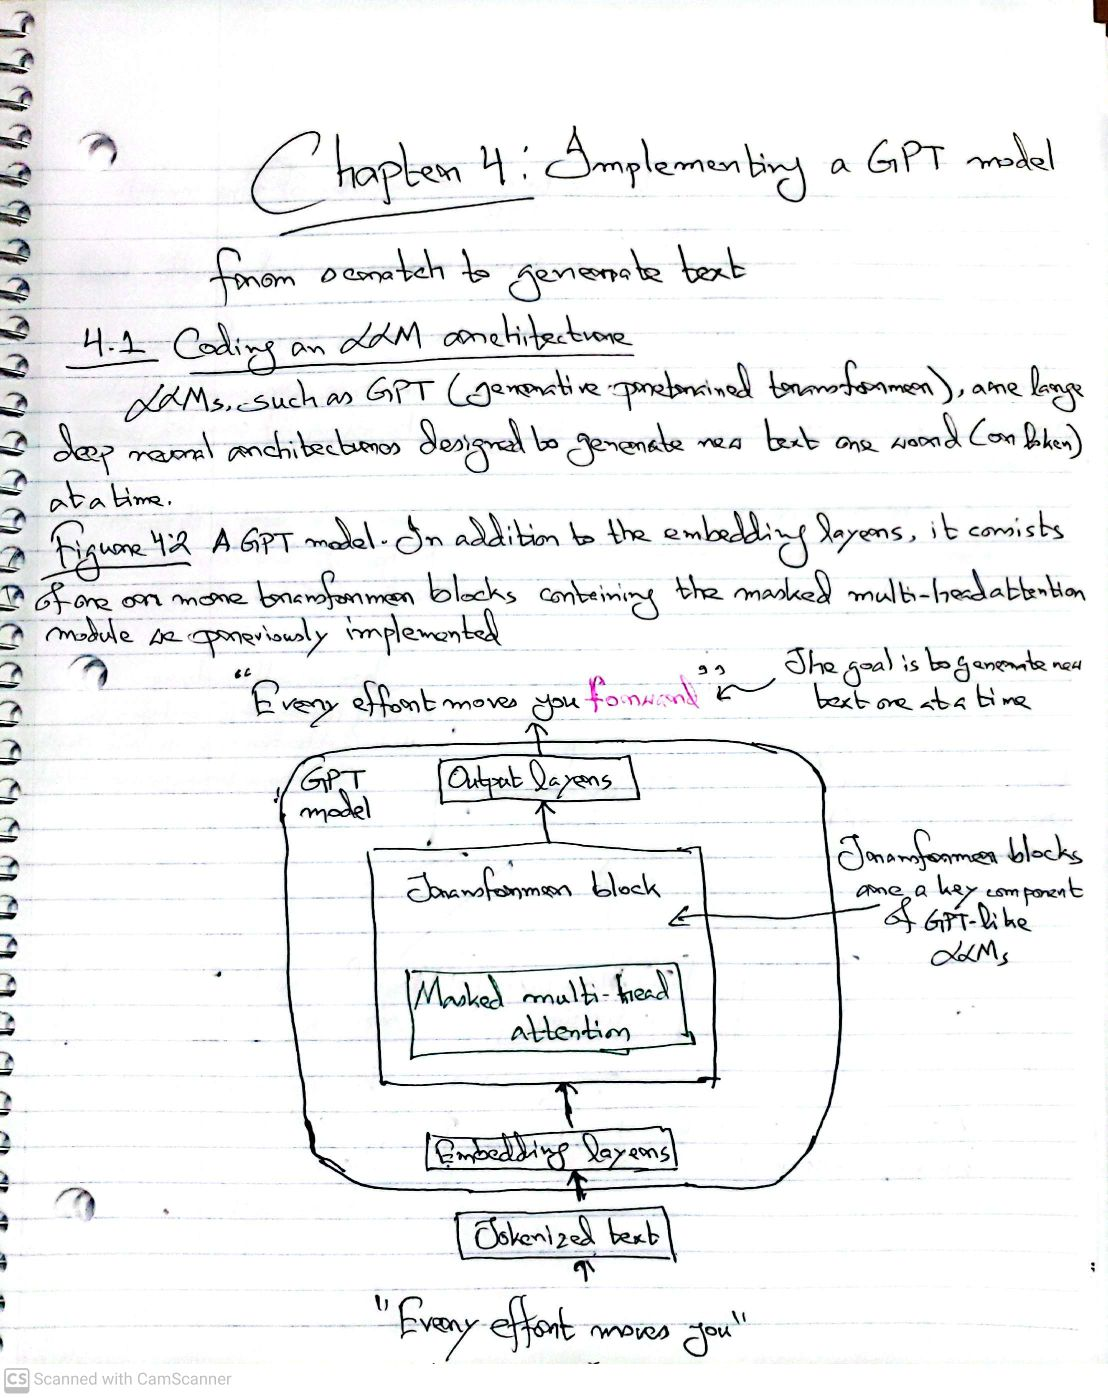

In [ ]:
display(Image(filename='0_1.jpg', width=800))

We already have implemented input tokenization, embedding, and the masked multi-head attention and now we will implement the core structure of the GPT model including transformer blocks. In this chapter, we will scale up to 124 million parameters GPT-2 model.

In deep learning, and in LLMs like GPT, "parameters" refer to the trainable weights of the model. For a neural network layer of 2048 x 2048 dimension, the total number of parameters for this layer is 2048 x 2048 or 4194304.

Let's specify the GPT configuration in a Python dictionary.

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers. Number of transformer blocks
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias. Whether to include a bias vector in the Linear layers of the multi-head attention for quer, key and value computations
}

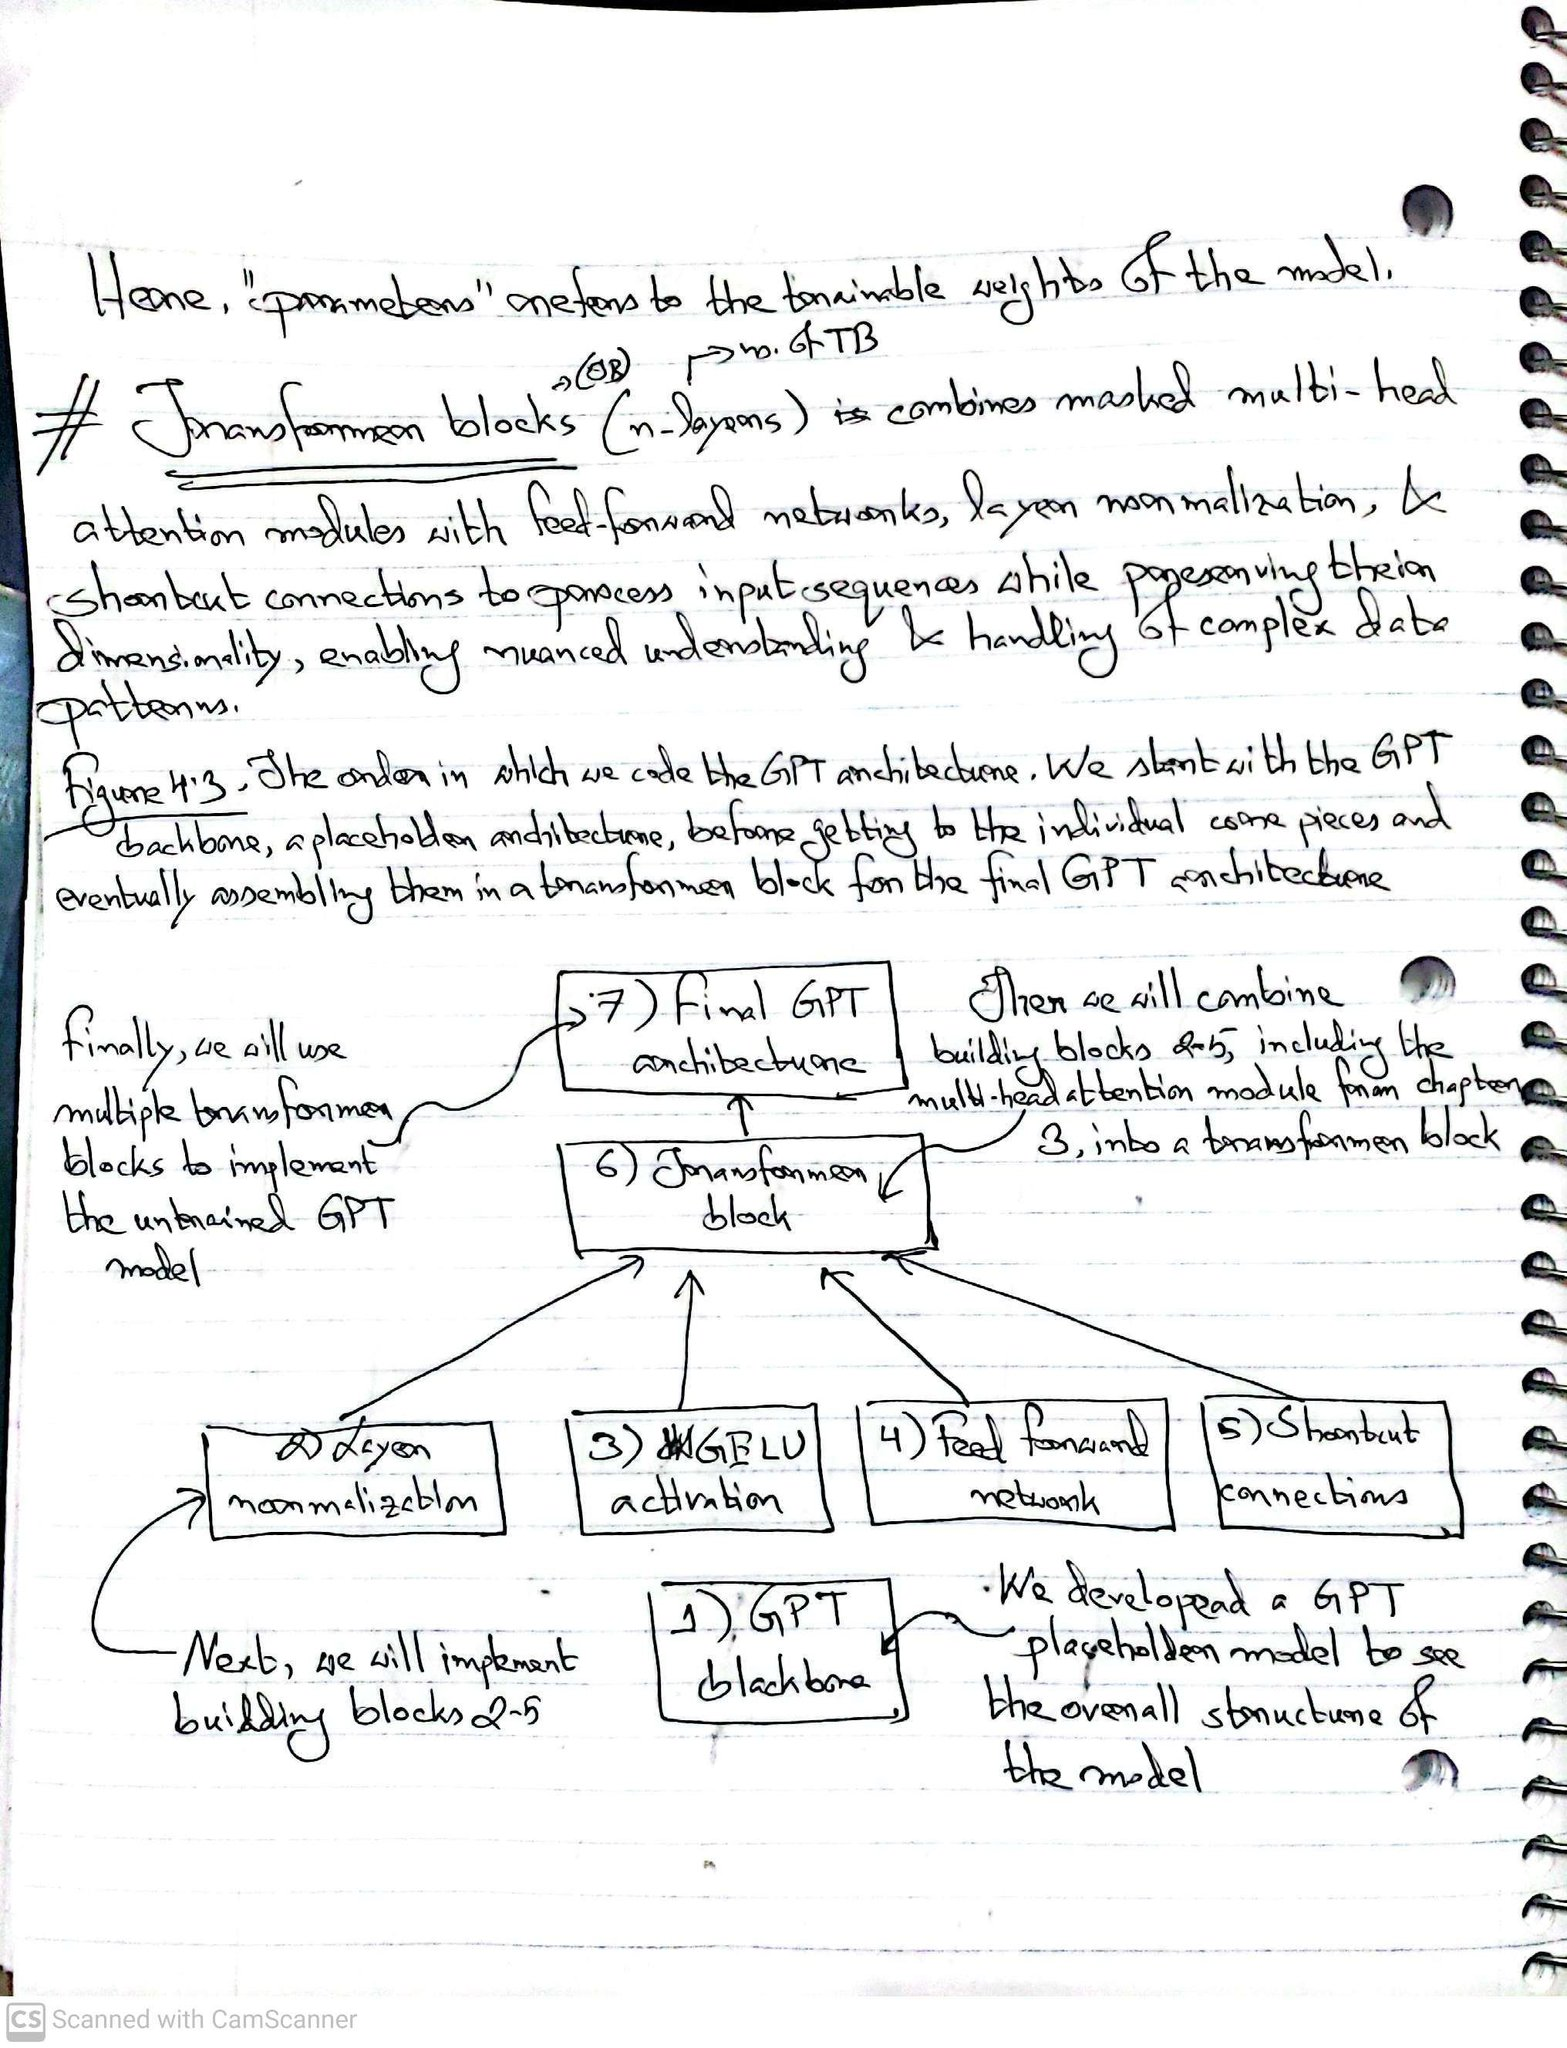

In [ ]:
display(Image(filename='0_2.jpg', width=800))

Now, we will implement building blocks 2-5 as shown in the figure above.

Now, we will implement the following GPT model architecture class.

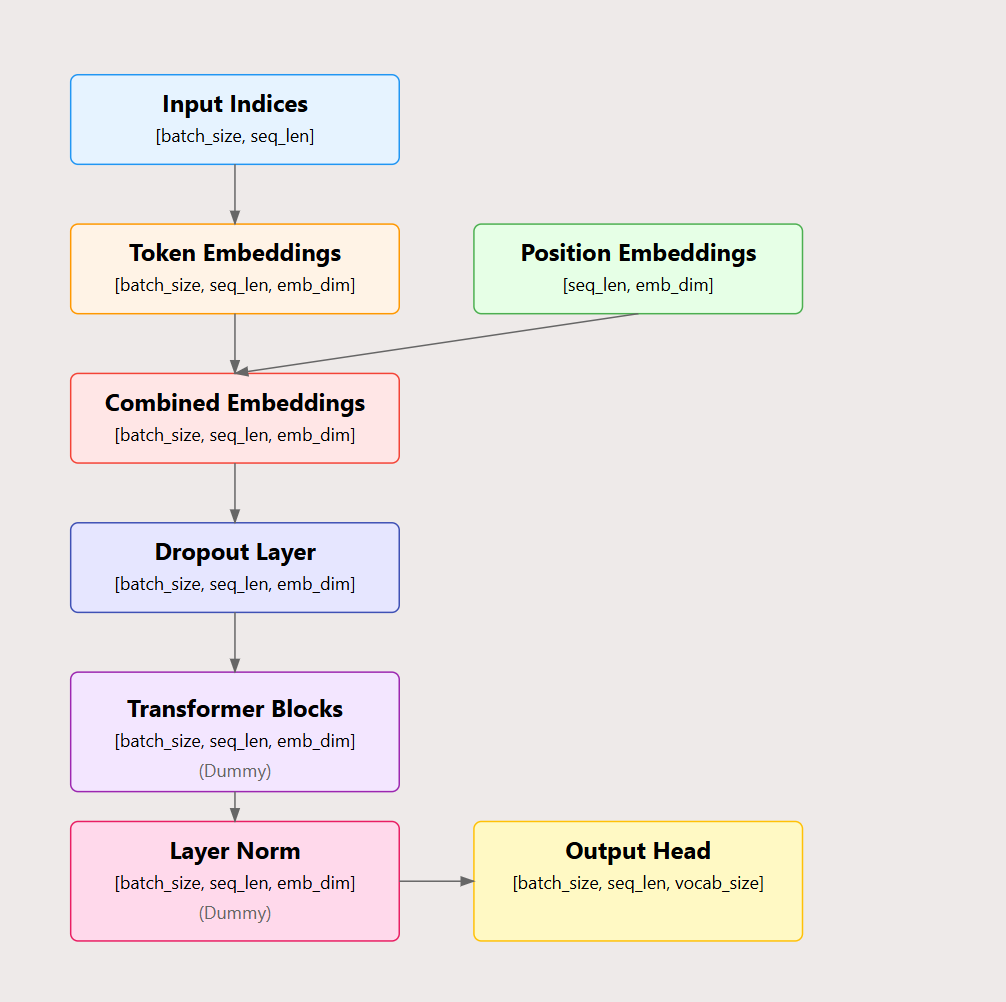

In [ ]:
display(Image(filename='1_2.png', width=800))

In the code below, DummyGPTModel class defines a simplified version of GPT like model (as shown in the figure above). It contains token and positional embeddings, dropout, a series of transformer blocks (`DummyTransformerBlock`), a final layer normalization (`DummyLayerNorm`), and a linear output layer (`out_head`). `DummyLayerNorm` and `DummyTransformerBlock` have not yet been implemented (will be done later) but the code will still run.

In [ ]:
import torch
import torch.nn as nn

# Define the main GPT model class
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        """
        Initialize the DummyGPTModel.

        Args:
            cfg (dict): Configuration dictionary containing model parameters.
        """
        super().__init__()

        # Token Embedding: Converts input token indices into dense vectors
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])

        # Positional Embedding: Adds information about the position of each token in the sequence
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])

        # Dropout layer to prevent overfitting by randomly setting a fraction of input units to 0
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Transformer Blocks: A stack of Transformer layers that process the embeddings
        # nn.Sequential is used to stack multiple layers in order
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg)
              for _ in range(cfg["n_layers"])]
        )

        # Final Layer Normalization to stabilize and normalize the output from the Transformer blocks
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])

        # Output Head: A linear layer that maps the final embeddings to vocabulary size for prediction
        # bias=False because typically biases are not used in the final output layer of language models
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        """
        Forward pass of the DummyGPTModel.

        Args:
            in_idx (torch.Tensor): Input tensor of token indices with shape (batch_size, seq_len).

        Returns:
            torch.Tensor: Logits for each token in the vocabulary.
        """
        batch_size, seq_len = in_idx.shape

        # Generate token embeddings for the input indices
        # Converts each token ID to its embedding vector
        tok_embeds = self.tok_emb(in_idx) # (batch_size, seq_len, emb_dim)

        # Generate positional embeddings based on the position of each token in the sequence
        # torch.arange: creates sequence [0, 1, 2, ..., seq_len-1]
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        ) # (seq_len, emb_dim)

        # Combine token and positional embeddings
        # Combines token and position information
        # Addition allows both types of information to flow through network
        x = tok_embeds + pos_embeds  # (batch_size, seq_len, emb_dim)

        # Apply dropout to the combined embeddings
        # randomly zeros out some values during training


        # Pass the embeddings through the stack of Transformer blocks
        x = self.trf_blocks(x)  # (batch_size, seq_len, emb_dim)

        # Apply layer normalization to the output of the Transformer blocks
        x = self.final_norm(x) # [batch_size, seq_len, emb_dim]

        # Generate logits by passing the normalized embeddings through the output head
        # Converts final representations to vocabulary predictions
        # Output shape: [batch_size, seq_len, vocab_size]
        logits = self.out_head(x) # (batch_size, seq_len, vocab_size)

        return logits

# Define a dummy Transformer block (placeholder for actual Transformer operations)
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        """
        Initialize the DummyTransformerBlock.

        Args:
            cfg (dict): Configuration dictionary (not used in this dummy implementation).
        """
        super().__init__()
        # In a real Transformer block, layers like Multi-Head Attention and Feed-Forward Networks would be defined here

    def forward(self, x):
        """
        Forward pass of the DummyTransformerBlock.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor (unchanged in this dummy implementation).
        """
        # For now, simply return the input tensor without any changes
        return x

# Define a dummy Layer Normalization (placeholder for actual normalization)
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        """
        Initialize the DummyLayerNorm.

        Args:
            normalized_shape (int): The shape of the input to be normalized.
            eps (float): A small value to prevent division by zero.
        """
        super().__init__()
        # In a real LayerNorm, learnable parameters for scaling and shifting would be defined here

    def forward(self, x):
        """
        Forward pass of the DummyLayerNorm.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor (unchanged in this dummy implementation).
        """
        # For now, simply return the input tensor without any changes
        return x

## **1. `self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])`**

- What is `nn.Embedding`?

  It’s a lookup table mapping token indices (integers) to dense vectors.

- **Input to this layer**:
A tensor of token IDs representing words or tokens, of shape:
  (batch_size, seq_len)

Each element is an integer token index in the range [0, vocab_size - 1].


- **Output from this layer:**

Each token ID is replaced by its embedding vector of size `emb_dim`, so the output shape is:

  (batch_size, seq_len, emb_dim)

**Example:**

```python
batch_size = 2
seq_len = 3
vocab_size = 5  # e.g. 5 unique tokens: 0,1,2,3,4
emb_dim = 4     # each token represented by a 4-dimensional vector

# Sample input (token IDs)
input_tokens = torch.tensor([
    [0, 1, 4],  # batch element 1
    [2, 3, 1]   # batch element 2
])  # Shape: (2, 3)

# Create embedding layer
tok_emb = nn.Embedding(vocab_size, emb_dim)

# Get embeddings
output = tok_emb(input_tokens)  
print(output.shape)  # (2, 3, 4)
```

## **2. `self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])`**

- This is similar to token embeddings, but instead of tokens, it embeds positions in the sequence.

- **Input:**
A tensor of position indices for each token in the sequence:
  (deq_len, )

Positions start from 0 up to `seq_len - 1`.

- **Output:**
For each position index, you get an embedding vector of size `emb_dim`:

  (seq_len, emb_dim)

**Example**

```python
context_length = 10
seq_len = 3
emb_dim = 4

pos_indices = torch.arange(seq_len)  # tensor([0,1,2]) shape: (3,)

pos_emb = nn.Embedding(context_length, emb_dim)
pos_vectors = pos_emb(pos_indices)  
print(pos_vectors.shape)  # (3, 4)
```

## **3. `self.drop_emb = nn.Dropout(cfg["drop_rate"])`**

- Input shape:
Usually same shape as embeddings or activations, e.g.,

  (batch_size, seq_len, emb_dim)

- **Output shape:**
Same as input shape (dropout does not change tensor shape).

- **What it does:**
Randomly zeroes some fraction of the values during training to help regularize.

```python
x = torch.randn(2, 3, 4)  # random tensor, shape (batch=2, seq=3, emb=4)

dropout = nn.Dropout(0.5)
output = dropout(x)  
print(output.shape)  # still (2, 3, 4)
```

## **4. `self.trf_blocks = nn.Sequential(...)`**

- This is a stack of Transformer blocks.

- **Input to each block:**

  (batch_size, seq_len, emb_dim)

- Output from each block:

  Usually same shape as input because Transformer layers are designed to maintain shape:

      (batch_size, seq_len, emb_dim)

- `nn.Sequential` just chains multiple such blocks, passing the output of one as input to the next.

```python
class DummyBlock(nn.Module):
    def forward(self, x):
        return x  # dummy block that returns input unchanged

blocks = nn.Sequential(*[DummyBlock() for _ in range(3)])

x = torch.randn(2, 3, 4)  # shape: (batch=2, seq=3, emb=4)
out = blocks(x)
print(out.shape)  # (2, 3, 4)
```

## **5. `self.final_norm = DummyLayerNorm(cfg["emb_dim"])`**

- LayerNorm normalizes over the **last dimension**, the embedding dimension.

- **Input shape:**
  (batch_size, seq_len, emb_dim)

- **Output shape:** Same as input.

## **6. `self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)`**

This is a fully connected linear layer applied **independently at each token position** to map from `emb_dim` to `vocab_size`.

- **Input shape:**

  (batch_size, seq_len, emb_dim)

- **Output shape:**

  (batch_size, seq_len, vocab_size)

- This output contains the **logits** or raw scores over the vocabulary for each token in the sequence.

```python
batch_size = 2
seq_len = 3
emb_dim = 4
vocab_size = 5

x = torch.randn(batch_size, seq_len, emb_dim)
out_head = nn.Linear(emb_dim, vocab_size, bias=False)
logits = out_head(x)
print(logits.shape)  # (2, 3, 5)
```

This is a GPT (Generative Pre-trained Transformer) model that takes a sequence of tokens (like words or subwords) and predicts the next token in the sequence. Think of it like predicting the next word in a sentence.

### Model Architecture Overview:
The main class DummyGPTModel processes input through several layers:

```
Input → Embeddings → Transformer Blocks → Normalization → Output Prediction
```

Let's look at the transformer blocks line:

```python
self.trf_blocks = nn.Sequential(
    *[DummyTransformerBlock(cfg)
      for _ in range(cfg["n_layers"])]
)
```

This line is doing several things:

- It creates multiple transformer blocks based on the number specified in `cfg["n_layers"]`
- The `for _ in range(cfg["n_layers"])` creates a list of transformer blocks
- `nn.Sequential` combines these blocks into a sequence where data will flow through each block one after another
- The `*` operator unpacks the list into individual arguments for `nn.Sequential`
- For example, if `n_layers=4`, it creates 4 transformer blocks connected in sequence.

Here, there is a key difference with and without the * operator.

WITHOUT the * operator:

```python
self.trf_blocks = nn.Sequential(
    [DummyTransformerBlock(cfg)
     for _ in range(cfg["n_layers"])]
)
```

The key difference is:

1. **WITH `*`**: The list is unpacked into separate arguments. If `n_layers=3`, it effectively becomes:

```python
nn.Sequential(
    DummyTransformerBlock(cfg),
    DummyTransformerBlock(cfg),
    DummyTransformerBlock(cfg)
)
```

2. **WITHOUT `*`**: The entire list is passed as a single argument:

```python
nn.Sequential(
    [DummyTransformerBlock(cfg), DummyTransformerBlock(cfg), DummyTransformerBlock(cfg)]
)
```

This would cause an error because `nn.Sequential` expects individual modules as arguments, not a list of modules. The error would look something like:

```python
TypeError: Sequential doesn't accept lists; please pass individual arguments or use *args syntax
```

Think of it like this:

- `nn.Sequential` is like a queue where data must flow through each component one by one
- With `*`, you're saying "here are the individual components to put in the queue"
- Without `*`, you're trying to put the entire list as one component in the queue, which doesn't work

That's why the `*` operator is necessary here - it unpacks the list into separate arguments that `nn.Sequential` can properly use to create the sequence of transformer blocks.

```python
device=in_idx.device
```

In PyTorch, code can run on different "devices" - typically either a CPU or a GPU. The device parameter tells PyTorch where to store and process the tensor data.
Let's break it down:

First, look at this part:

```python
torch.arange(seq_len, device=in_idx.device)
```

- torch.arange(seq_len) creates a sequence of numbers from 0 to seq_len-1

- If seq_len=5, it creates: `[0, 1, 2, 3, 4]`


The `device=in_idx.device` part:

- It checks which device (CPU or GPU) the input tensor `in_idx` is on
- It then creates the new tensor on the same device.

So `device=in_idx.device` ensures that:

1. All tensors are on the same device
2. The code works seamlessly whether you're using CPU or GPU
3. You avoid "cuda error" messages that happen when mixing CPU and GPU tensors.

## 1. `DummyTransformerBlock` Class
```python
class DummyTransformerBlock(nn.Module):
```

### **Function and Purpose:**
- **Placeholder for Transformer Operations:** The DummyTransformerBlock serves as a **stand-in** for a real Transformer block. In actual implementations, a Transformer block typically consists of components like:

  - **Multi-Head Self-Attention**: Allows the model to focus on different parts of the input sequence simultaneously.
  - **Feed-Forward Neural Networks (FFNN)**: Processes the outputs from the attention mechanism to introduce non-linearity.
  - **Residual Connections and Layer Normalization**: Helps in stabilizing training and allows gradients to flow more easily.
- Structure for Future Implementation: By creating a dummy class, it sets up the architecture of the model without delving into the complexities of implementing a full Transformer block immediately. This approach allows for:

  - Incremental Development: Building and testing the model's structure before adding detailed functionalities.
  - Placeholder Flexibility: Easily replacing the dummy block with a fully functional Transformer block later without altering the overall model architecture.

### **How we plan to use it**
- **Stacking Transformer Blocks**: In the DummyGPTModel, multiple instances of DummyTransformerBlock are stacked sequentially using nn.Sequential. This mirrors how Transformer-based models like GPT are built by stacking several Transformer layers to capture complex patterns in data.

- **Facilitating Model Expansion**: Once the basic model structure is verified, we replace `DummyTransformerBlock` with a comprehensive Transformer implementation, enhancing the model's capabilities.

## 2. DummyLayerNorm Class

```python
class DummyLayerNorm(nn.Module):
```

### **Function and Purpose**:
- **Placeholder for Layer Normalization**: The DummyLayerNorm acts as a stand-in for the actual Layer Normalization layer. In practice, Layer Normalization:

 - **Stabilizes Training**: By normalizing the inputs across the features, it helps in stabilizing and accelerating the training process.
 - **Learnable Parameters**: Typically includes learnable scaling (gamma) and shifting (beta) parameters that allow the model to adjust the normalization dynamically.

- **Structure for Future Implementation**: Similar to the `DummyTransformerBlock`, this dummy class allows the author to outline the model's architecture without implementing the full normalization logic immediately.

### **How we plan to use it**:
- **Final Normalization Step**: In the `DummyGPTModel`, after passing the data through the Transformer blocks, `DummyLayerNorm` is applied. This mirrors the standard practice in Transformer-based models where a final normalization step ensures that the output embeddings are well-scaled and stable before being passed to the output layer.

- **Ease of Integration**: By having a dummy normalization layer, the author can later integrate a fully functional `LayerNorm` without restructuring the model. This modularity facilitates easier updates and maintenance.

Let's break down the forward method in detail. This method is the core of how the model processes input data:

```python
def forward(self, in_idx):
    # Get input dimensions
    batch_size, seq_len = in_idx.shape
```

First, it takes an input tensor `in_idx` containing token indices and extracts its dimensions:

- **batch_size**: number of sequences being processed at once
- **seq_len**: length of each sequence

```python
# Step 1: Token Embeddings
tok_embeds = self.tok_emb(in_idx)
```

Converts each token ID into a vector representation (embedding). For example, if the word "cat" has ID 42, it gets converted into a vector of numbers that represents its meaning.

```python
# Step 2: Position Embeddings
pos_embeds = self.pos_emb(
    torch.arange(seq_len, device=in_idx.device)
)
```
Creates embeddings for each position in the sequence (0, 1, 2, etc.). This helps the model understand word order - for example, that "cat" is the first word in the sentence.

```python
# Step 3: Combine Embeddings
x = tok_embeds + pos_embeds
```

Adds together the token and position information. Now each word's representation contains both what the word means and where it appears in the sequence.

```python
# Step 4: Dropout
x = self.drop_emb(x)
```

Randomly zeros out some values during training to prevent overfitting.

```python
# Step 5: Transformer Processing
x = self.trf_blocks(x)
```

Passes the embeddings through the transformer blocks, where each token can interact with all other tokens in the sequence.

```python
# Step 6: Final Normalization
x = self.final_norm(x)
```
Normalizes the outputs to help with training stability.

```python
# Step 7: Generate Predictions
logits = self.out_head(x)
```
Converts the final representations into predictions for each position in the sequence. For each position, it produces a score (logit) for every possible token in the vocabulary.

```python
return logits
```

Returns these predictions, which can then be used to:

- During training: calculate loss by comparing with actual next tokens
- During generation: select the next token to generate
- During inference: analyze probabilities of different possible next tokens

The output shape is [batch_size, seq_len, vocab_size], meaning for each position in each sequence, we get scores for every possible token in our vocabulary.

Let's say we're working with a tiny vocabulary of just 5 words:

```python
vocabulary = {
    "cat": 0,
    "dog": 1,
    "runs": 2,
    "jumps": 3,
    "fast": 4
}
```

Now, let's say we input two short sentences (batch_size = 2), each with 3 words (seq_len = 3):

```python
Sentence 1: "cat runs fast"
Sentence 2: "dog jumps fast"
```

The output shape [batch_size=2, seq_len=3, vocab_size=5] would look like this:

```python
Sentence 1 probabilities:
Position 1: [0.1, 0.2, 0.4, 0.1, 0.2]  # Scores for: [cat, dog, runs, jumps, fast]
Position 2: [0.1, 0.1, 0.5, 0.2, 0.1]  # Scores for: [cat, dog, runs, jumps, fast]
Position 3: [0.1, 0.1, 0.1, 0.1, 0.6]  # Scores for: [cat, dog, runs, jumps, fast]

Sentence 2 probabilities:
Position 1: [0.2, 0.5, 0.1, 0.1, 0.1]  # Scores for: [cat, dog, runs, jumps, fast]
Position 2: [0.1, 0.1, 0.2, 0.5, 0.1]  # Scores for: [cat, dog, runs, jumps, fast]
Position 3: [0.1, 0.1, 0.1, 0.1, 0.6]  # Scores for: [cat, dog, runs, jumps, fast]
```

So for each position in each sentence:

- Position 1: The model predicts how likely each word in our vocabulary is to appear first
- Position 2: The model predicts how likely each word is to appear second
- Position 3: The model predicts how likely each word is to appear third

In visual form:

```python
[batch_size=2, seq_len=3, vocab_size=5]

Sentence 1:
Position 1: [cat    dog    runs   jumps  fast]
           [0.1    0.2    0.4    0.1    0.2]

Position 2: [cat    dog    runs   jumps  fast]
           [0.1    0.1    0.5    0.2    0.1]

Position 3: [cat    dog    runs   jumps  fast]
           [0.1    0.1    0.1    0.1    0.6]

Sentence 2:
... (similar structure for second sentence)
```

In a real GPT model:

- The vocabulary would be much larger (often 50,000+ tokens)
- The sequences could be longer
- You might process many sentences at once
- The scores would be used to predict the next word in the sequence

But the basic idea is the same: for every position in every input sequence, the model outputs a score for how likely each possible word in our vocabulary is to appear in that position.

When we say the output shape is [batch_size, seq_len, vocab_size], think of it as a 3D structure, like a cube. Let's break it down with specific numbers:

```python
# Example dimensions
batch_size = 2    # Processing 2 sentences
seq_len = 3       # Each sentence has 3 words
vocab_size = 5    # Vocabulary has 5 words

# Our tiny vocabulary
vocab = ["cat", "dog", "runs", "jumps", "fast"]

# Input sentences
sentences = [
    "cat runs fast",    # Sentence 1
    "dog jumps fast"    # Sentence 2
]
```

The output logits (scores) would be a 3D tensor with shape [2, 3, 5]. Let's visualize it:

```python
# First dimension (batch_size=2):
# Two separate "sheets" for each sentence

Sentence 1 [0, :, :]:
Position →     1         2         3
           ┌─────────┬─────────┬─────────┐
cat     │   0.9   │   0.1   │   0.1   │
dog     │   0.1   │   0.1   │   0.1   │
runs    │   0.0   │   0.6   │   0.1   │
jumps   │   0.0   │   0.1   │   0.1   │
fast    │   0.0   │   0.1   │   0.6   │
           └─────────┴─────────┴─────────┘

Sentence 2 [1, :, :]:
Position →     1         2         3
           ┌─────────┬─────────┬─────────┐
cat     │   0.1   │   0.1   │   0.1   │
dog     │   0.8   │   0.1   │   0.1   │
runs    │   0.0   │   0.1   │   0.1   │
jumps   │   0.1   │   0.6   │   0.1   │
fast    │   0.0   │   0.1   │   0.6   │
           └─────────┴─────────┴─────────┘
```

To access specific probabilities:

```python
# Shape: [batch_size=2, seq_len=3, vocab_size=5]
logits = model(input_tokens)

# To get probabilities for:
# Sentence 1, Position 1, all words
probs_sent1_pos1 = logits[0, 0, :]  # [0.9, 0.1, 0.0, 0.0, 0.0]

# Sentence 2, Position 2, all words
probs_sent2_pos2 = logits[1, 1, :]  # [0.1, 0.1, 0.1, 0.6, 0.1]

# All positions for Sentence 1
probs_sent1 = logits[0, :, :]  # First "sheet" of the cube

# Probability of "fast" at Position 3 in Sentence 2
prob_fast_sent2_pos3 = logits[1, 2, 4]  # 0.6
```

The indexing works like this:

- First index: Which sentence (0 or 1)
- Second index: Which position in the sentence (0, 1, or 2)
- Third index: Which word in vocabulary (0 to 4)

Each "cell" in this 3D structure contains the score/probability for a specific word, at a specific position, in a specific sentence. We're not getting different probabilities for each position - instead, we're getting a full set of vocabulary probabilities for each position in each sentence.

### **seq_len is working as positional index**

The `seq_len` dimension acts as the positional index in the sequence. Let us explain with a very simple example:

Let's say we have:

```python
batch_size = 1      # One sentence
seq_len = 4        # Sentence length of 4 words
vocab_size = 3     # Tiny vocabulary: ["cat", "runs", "fast"]
```

When the model processes an input like "cat runs fast cat", each position (0 to 3) in the sequence gets its own set of predictions for all possible words:

```python
Position 0 (seq_len=0): First word
[0.7, 0.2, 0.1]   # Probabilities for [cat, runs, fast]

Position 1 (seq_len=1): Second word
[0.1, 0.8, 0.1]   # Probabilities for [cat, runs, fast]

Position 2 (seq_len=2): Third word
[0.1, 0.1, 0.8]   # Probabilities for [cat, runs, fast]

Position 3 (seq_len=3): Fourth word
[0.6, 0.2, 0.2]   # Probabilities for [cat, runs, fast]
```

So when we access `logits[0, 2, :]`, we're saying:

- `0`: First sentence in the batch
- `2`: Third position in the sequence
- `:`: All vocabulary scores for that position

This is why it's crucial for language modeling - the model learns what words are likely to appear at each position in a sequence, given the previous words.


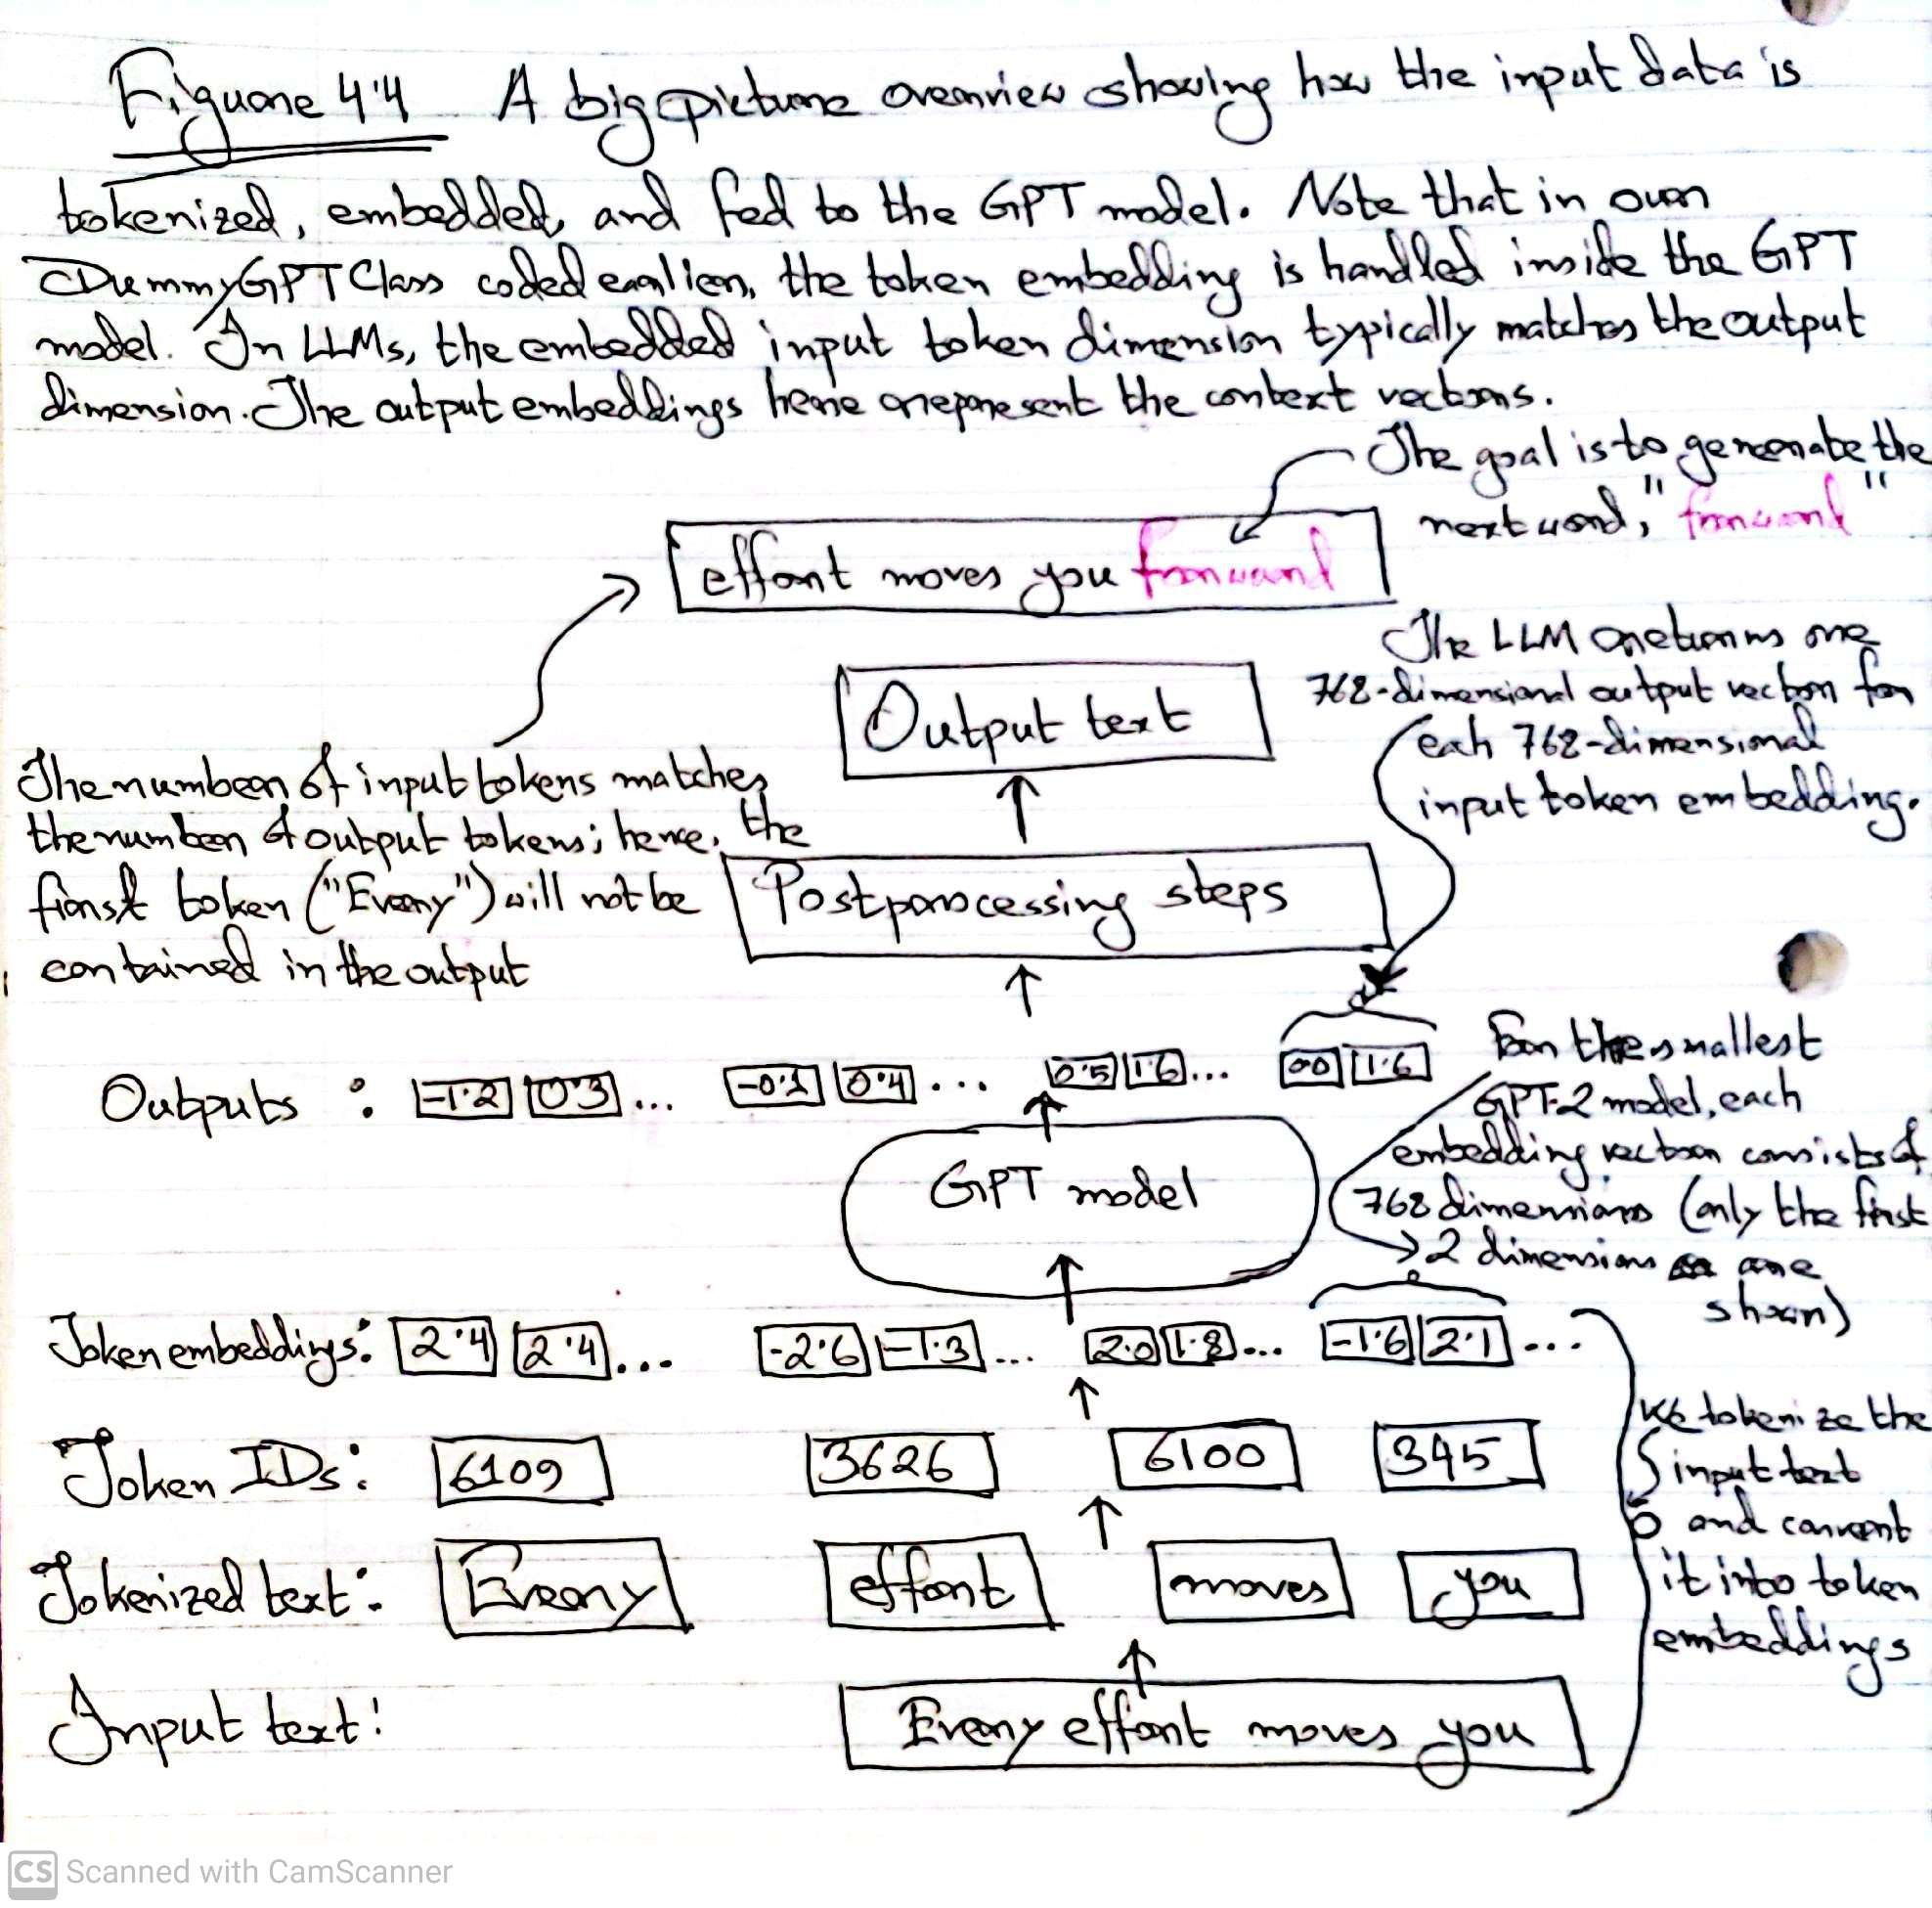

In [ ]:
display(Image(filename='4_4.jpg', width=800))

Now, let's implement these steps. Start by tokenizing two text inputs. First install the tiktoken package that we will use to tokenize texts.

In [ ]:
!pip install tiktoken

In [ ]:
import tiktoken

print(tiktoken.list_encoding_names())

['gpt2', 'r50k_base', 'p50k_base', 'p50k_edit', 'cl100k_base', 'o200k_base']


In [ ]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


Now, we will define the configuration of the GPT-2 model inside a disctionary.

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 1024, # Context_length
    "emb_dim": 768, # Embedding dimension
    "n_layers": 12, # Number of transformer blocks
    "n_heads": 12, # Number of attention heads
    "drop_rate": 0.1, # Dropout rate
    "qkv_bias": False # Quer-Key-Value bias -- determines whether to include a bias vector in the Linear layers of the multi-head attention for query, key and value computations
}

Here, `context_length` refers to the maximum number of input tokens the model can handle through positional embeddings.

Now, using this, we will initialize a 124-million-parameter `DummyGPTModel` instance.

In [ ]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print(logits)

tensor([[[-1.1947,  0.1392, -0.8616,  ..., -1.4987, -0.0314, -0.4490],
         [ 0.0497,  0.3861, -0.3281,  ..., -0.1826,  1.3084,  0.9867],
         [ 0.7005,  1.4747, -0.4149,  ...,  1.7756, -0.2280,  0.5384],
         [ 0.4885,  1.7545, -0.6707,  ...,  1.1501, -0.1143, -0.9368]],

        [[-1.1947,  0.1392, -0.8616,  ..., -1.4987, -0.0314, -0.4490],
         [-0.5591,  0.5797, -0.1296,  ...,  0.2691,  0.3151,  1.4046],
         [ 0.8524,  1.2833, -0.1786,  ..., -0.1982,  0.1097,  0.2812],
         [-0.0190, -0.8277,  0.2299,  ...,  1.7974, -0.1646, -0.1049]]],
       grad_fn=<UnsafeViewBackward0>)


In [ ]:
logits.shape

torch.Size([2, 4, 50257])

It has two rows corresponding to two text samples. Here each sample has 4 tokens and each token has a 50,257 dimensional embedding. In the postprocessing stage, we will convert these 50,257 dimensional vectos back into token IDs, from which we will further decode them into words.

## **4.2 Normalizing activations with layer normalization**

It helps in addressing the problems of vanishing or exploding gradients. This adjusts the activations or outputs of a neural network layer to have a mean of 0 and variance of 1. This allows to speed up the convergence to effective weights and to have consistent and reliable training. In GPT-2 and modern transformer architectures, this is applied before and after the multi-head attention module and also before the final output layer. The figure below shows the functioning of layer normalization.

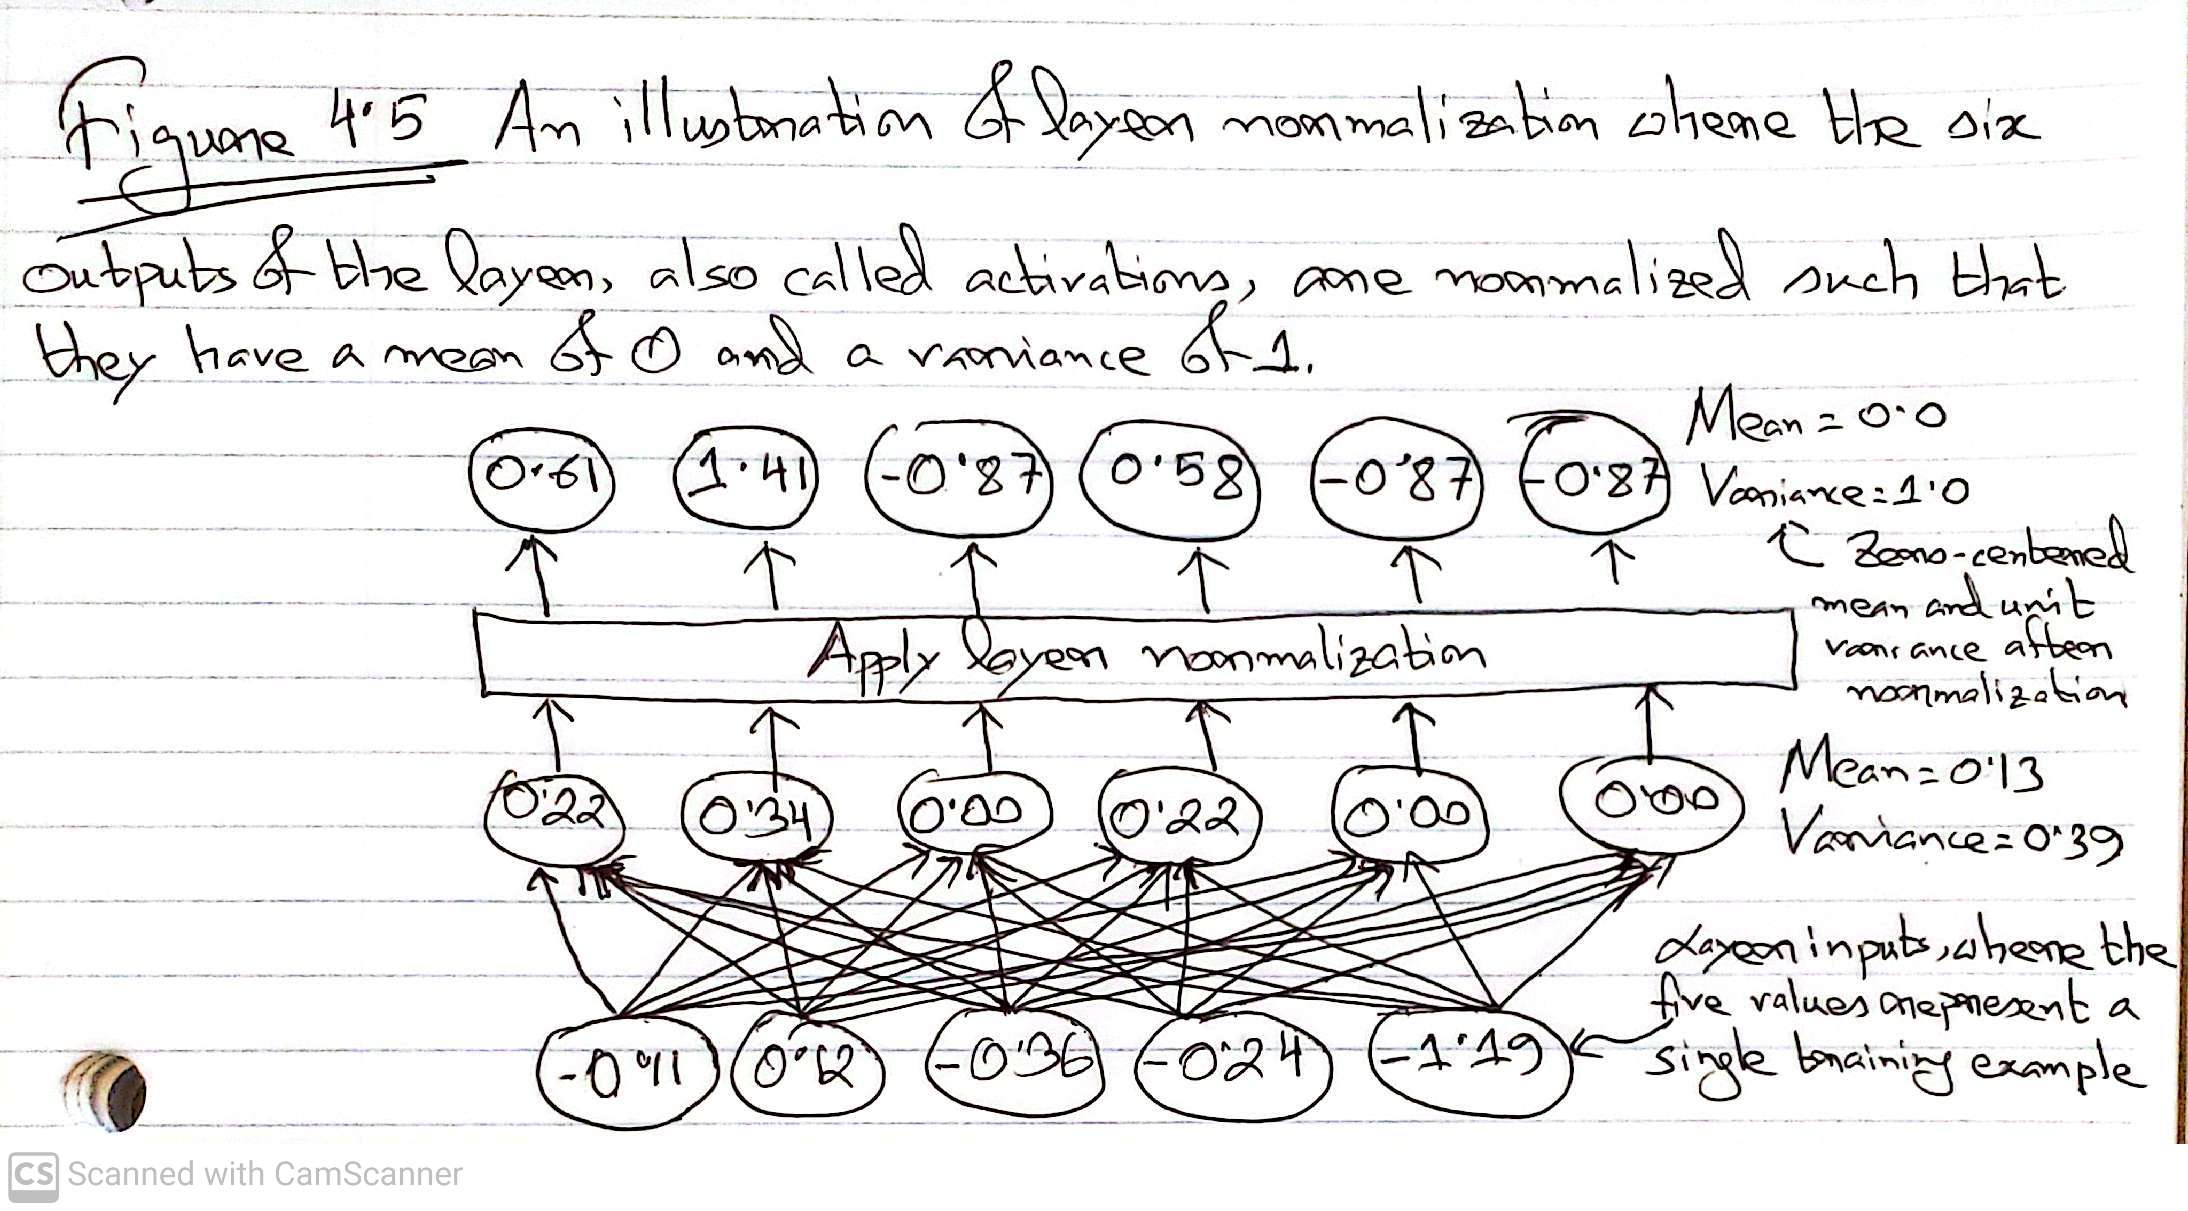

In [ ]:
display(Image(filename='4_5.jpg', width=800))

Now, we will try to implement the above by implementing a neural network layer for two input examples, five inputs and six outputs.

In [ ]:
# Neural net with five inputs and 6 outputs
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU()) # fully connected (linear) layer -- it takes an input of size 5 and produces an output of size 6.
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


Mean and variance before applying normalization

In [ ]:
mean = out.mean(dim=-1, keepdims=True)
var = out.var(dim=-1, keepdims=True)
print("Mean\n", mean)
print("Variance:\n", var.shape)

Mean
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 torch.Size([2, 1])


Using `keepdims`, we have been able to get a 2x1 dimensional matrix, without using which we would have got a vector of size 2.

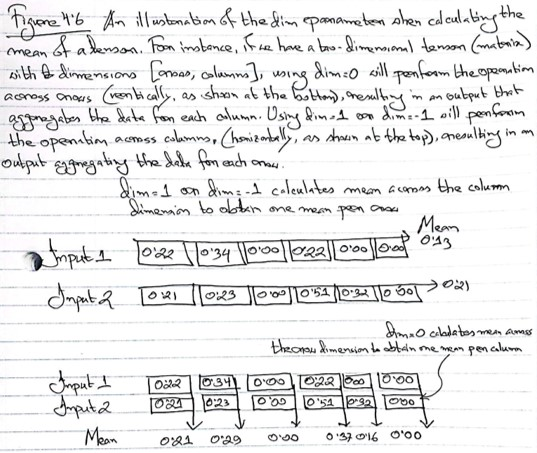

In [ ]:
display(Image(filename='4_6.jpg', width=800))

Now, let's apply the normalization to the layer outputs.

In [ ]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdims=True)
var = out_norm.var(dim=-1, keepdims=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Now, we can see that after normalization, the mean of this normalized layer is 0 and variance is 1.

Turn off scientific notation for better readability:

In [ ]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Now, let's do this by creating a class encapsulating the process in a PyTorch module.

In [ ]:
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdims=True)
    var = x.var(dim=-1, keepdims=True, unbiased=False) # unbiased=False results in the division by n instead of n-1
    # Dividing by n-1 is known as Bessel's correction. So, we have biased estimate of variance.
    # GPT-2 was implemented using Tensorflow that used this approach. Also for LLMs, the difference between
    # n and n-1 is practically negligible.
    norm_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift

### **Scale and Shift:**
After normalization, the values are adjusted using trainable parameters self.scale and self.shift. This lets the model learn the best way to scale and shift the normalized values for the specific task.

### **Why Multiply by self.scale and Add self.shift?**

1. **Multiplying by `self.scale`:**

 - The normalized values (mean 0, variance 1) are sometimes too "flat" (too spread out).
 - self.scale allows the model to stretch or compress these values. Think of it as deciding "how big" or "how small" the numbers should be.

2. **Adding `self.shift`**:

 - The normalized values (centered at 0) might not always be ideal for the task.
 - `self.shift` lets the model move the values up or down to a better range. Think of it as deciding "where the center" of the numbers should be.

These two operations give the model flexibility to "undo" or "adjust" the normalization if the raw normalized values aren't perfect for the task.

### **Why Rescale After Normalization?**

Normalization alone forces the data to have a fixed mean (0) and variance (1). However, this may not be ideal for the task. **Rescaling and shifting** introduce **flexibility**, allowing the model to "learn" the best scale and offset for the task during training.

#### **Here’s Why We Need Rescaling and Shifting:**

1. **Restoring Representation Power**

 - When we normalize, we remove the model’s ability to represent features at their original scale. For some tasks, this original scale or a task-specific scale might matter.
 - Rescaling (`self.scale`) and shifting (`self.shift`) allow the model to restore the flexibility to represent the data in a way that best suits the task.

2. **Learnable Parameters**

- During training, the model adjusts `self.scale` and `self.shift` to find the optimal scale and offset for the specific task and data. This makes normalization adaptive rather than fixed.

3. **Task-Specific Adjustments**

For certain tasks, the normalized data (mean 0, variance 1) might not be the ideal range for downstream operations. The trainable parameters allow the model to shift and scale the normalized values to whatever range is most effective.


Let's use the `LayerNorm` module now.

In [ ]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdims=True)
var = out_ln.var(dim=-1, unbiased=False, keepdims=True)
print("Mean:\n", mean)
print("Var:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Var:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


We coded two of the building blocks of the GPT architecture and look at GELU activation and feed forward network next.

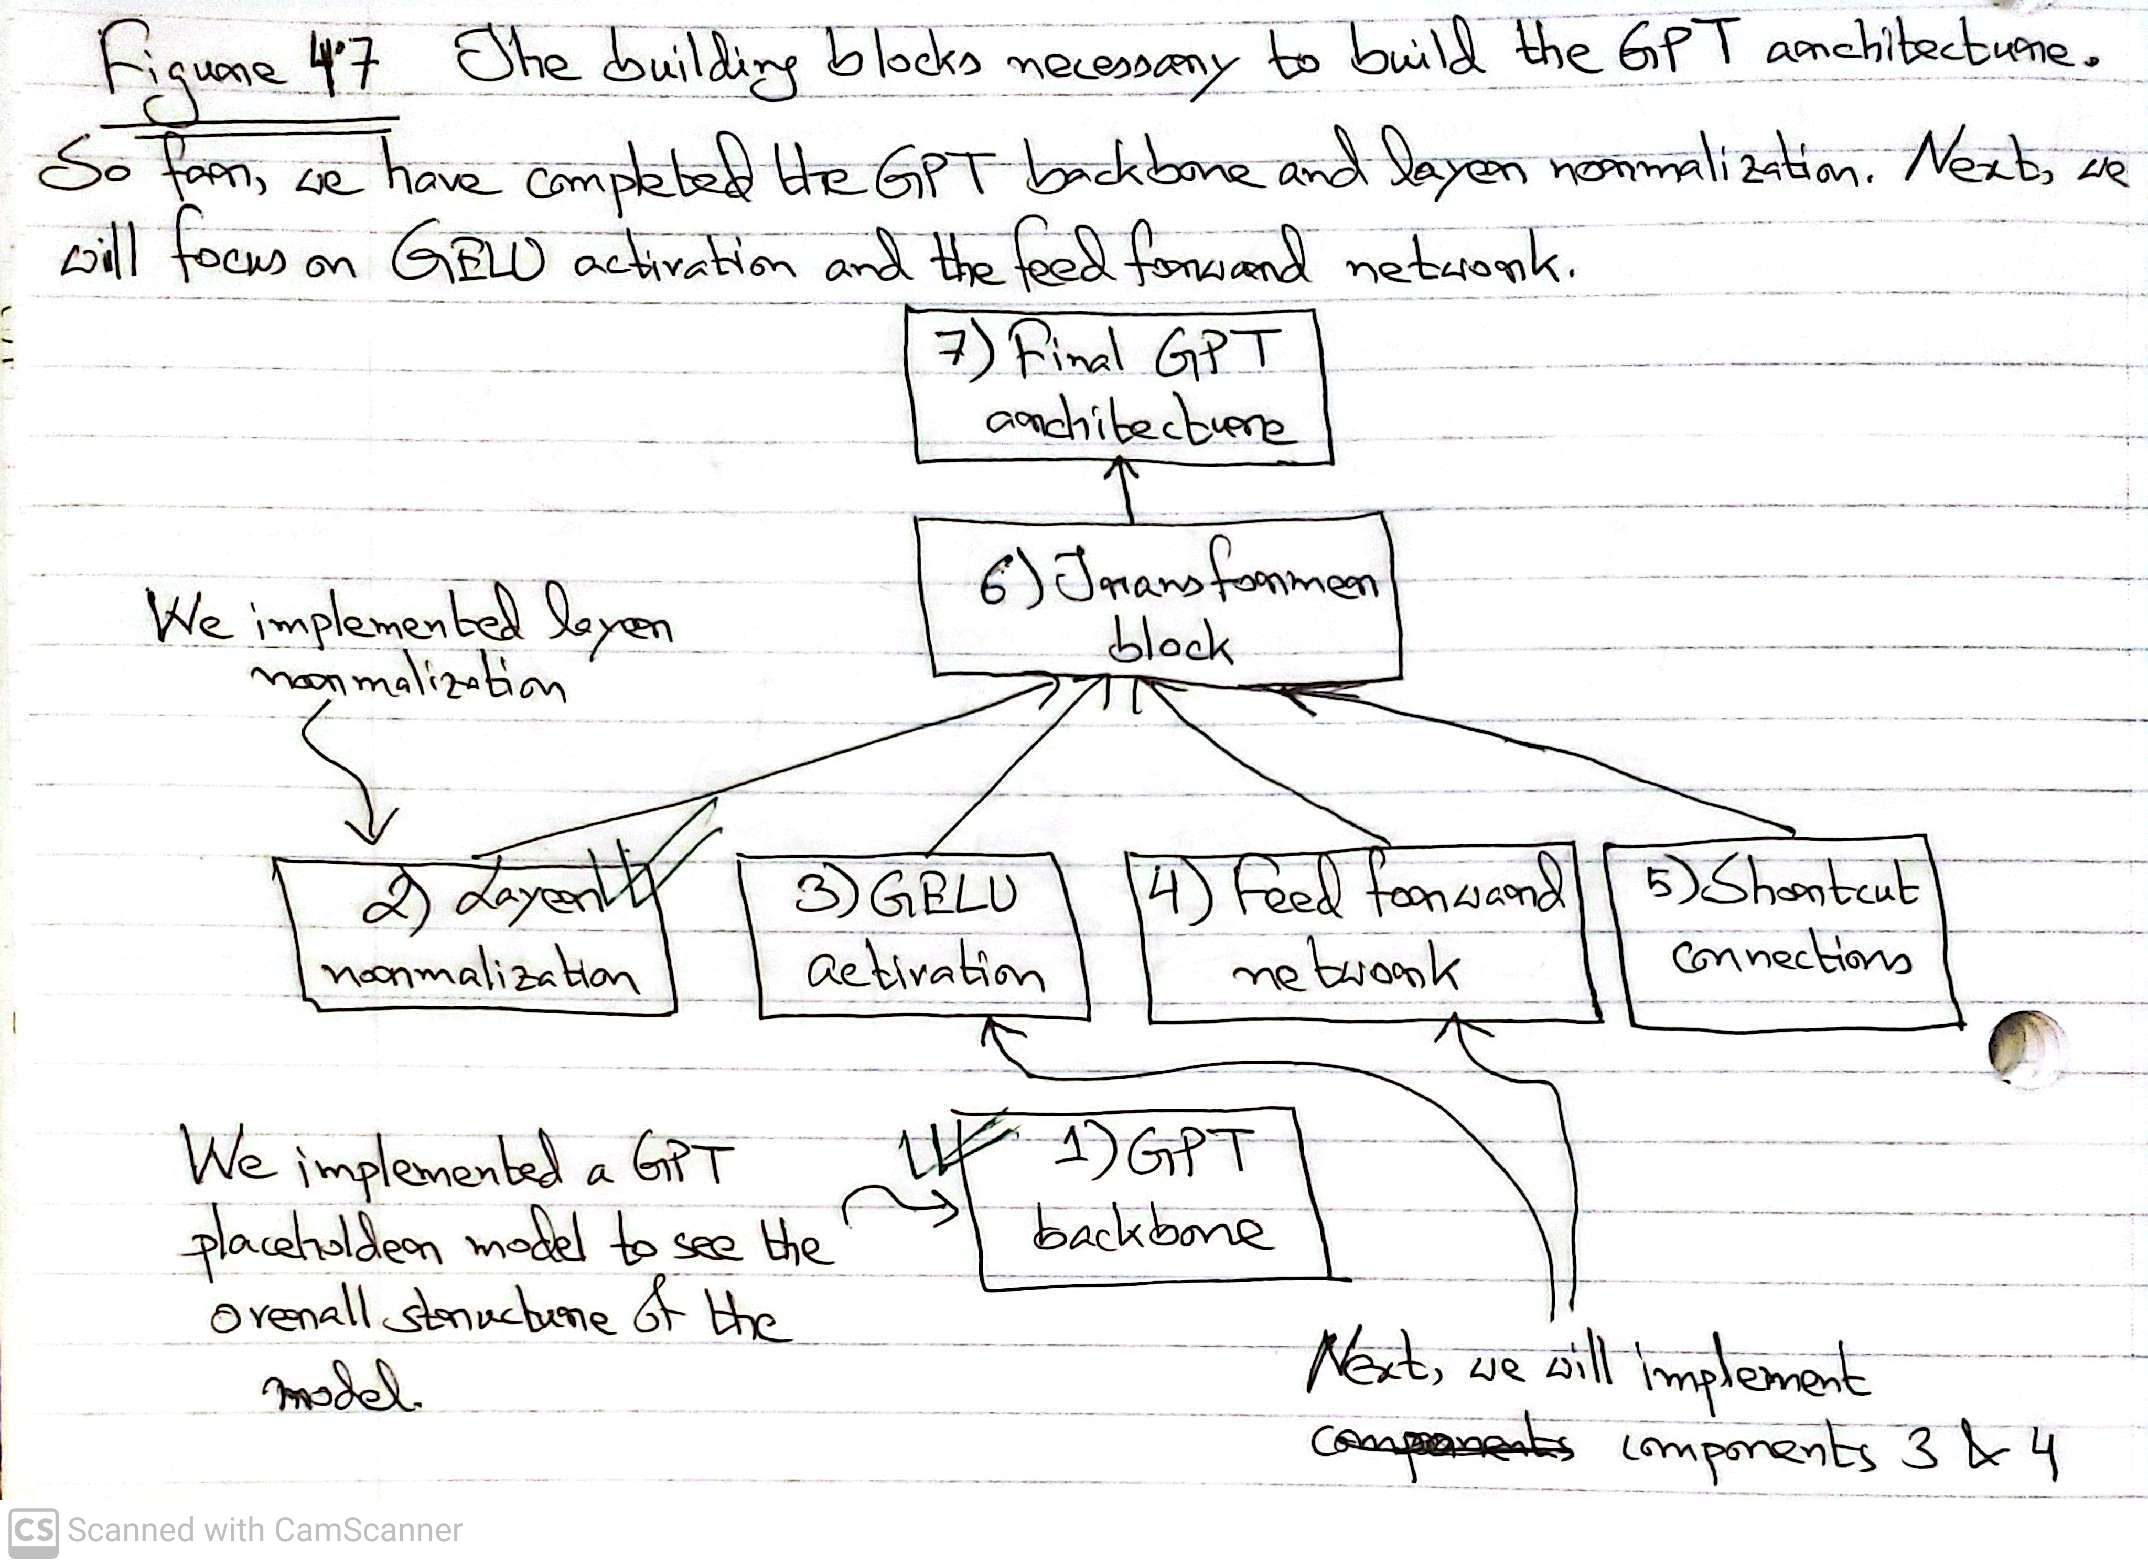

In [ ]:
display(Image(filename='4_7.jpg', width=800))

## **4.3 Implementing a feed forward network with Gaussian Error Linear Unit (GELU) activations**

Unlike **ReLU**, **GELU** allows small non-zero output for negative values. This allows for the neurons with negative input to still contribute slightly to the training process. GELU offers better performance for deep learning models.

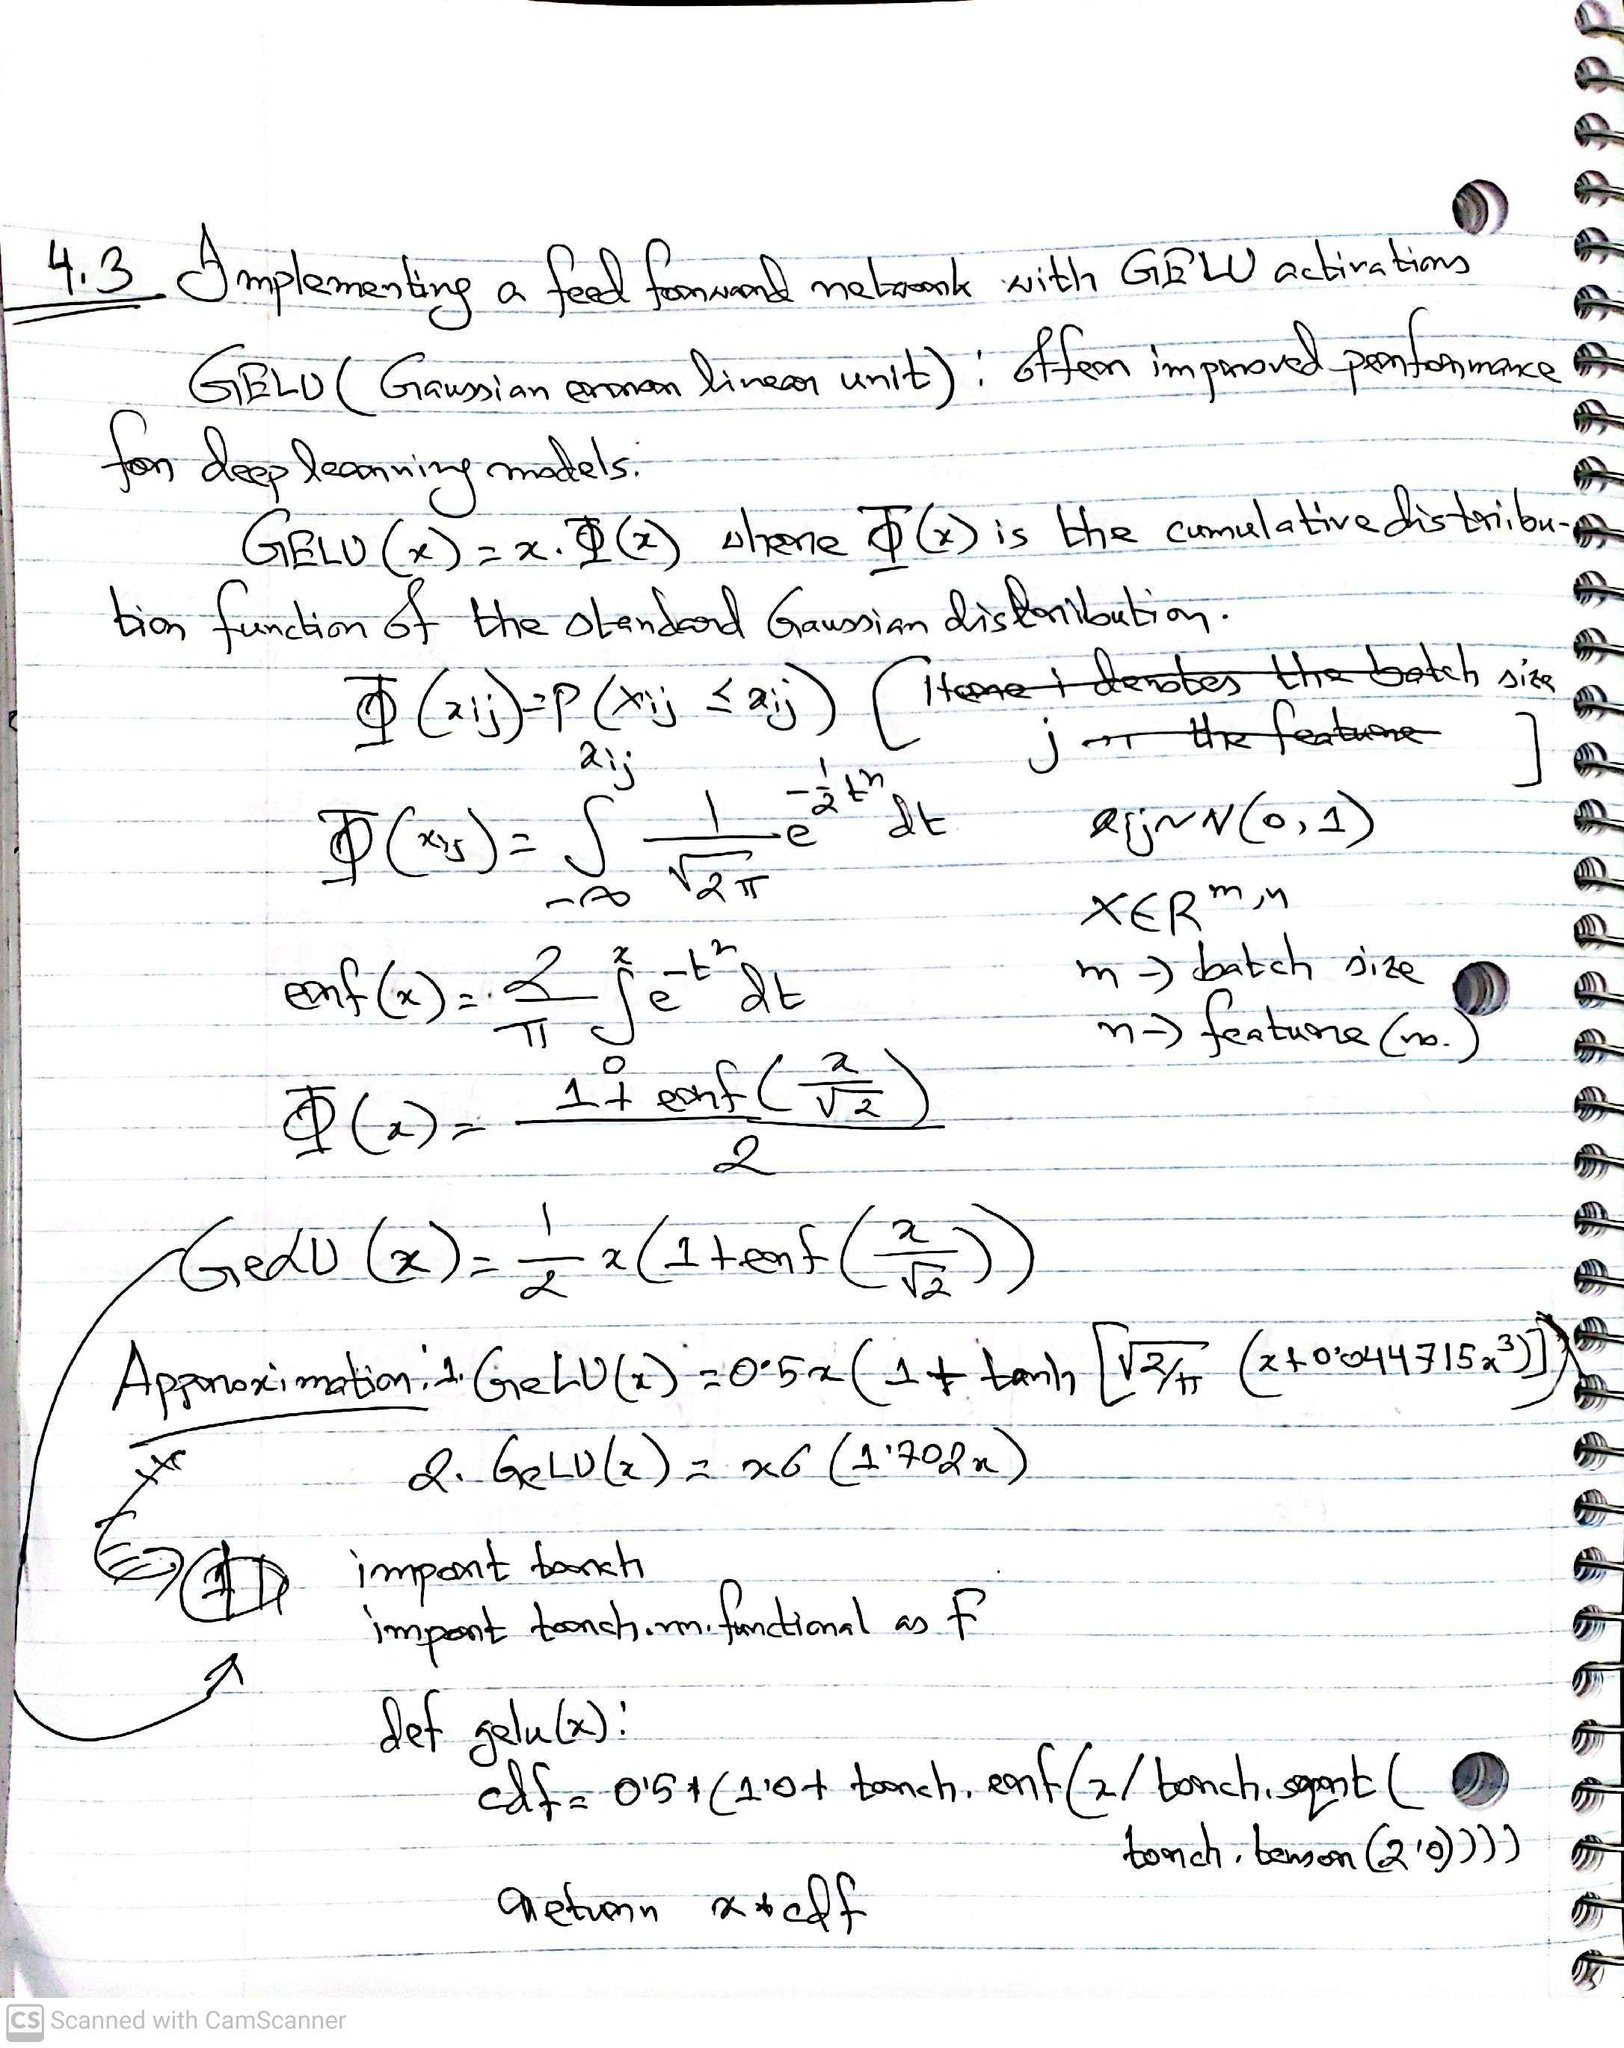

In [ ]:
display(Image(filename='GeLU.jpg', width=800))

**GeLU implementation using ERF**

In [ ]:
import torch
import torch.nn.functional as F

def gelu_erf(x):
  cdf = 0.5 * (1.0 + torch.erf(x / torch.sqrt(torch.tensor(2.0))))
  return x * cdf

**GeLU implementation using approximation 1**

In [ ]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) *
                                     (x + 0.044715 * torch.pow(x, 3))
                                     ))

**Compare ReLU against GeLU**

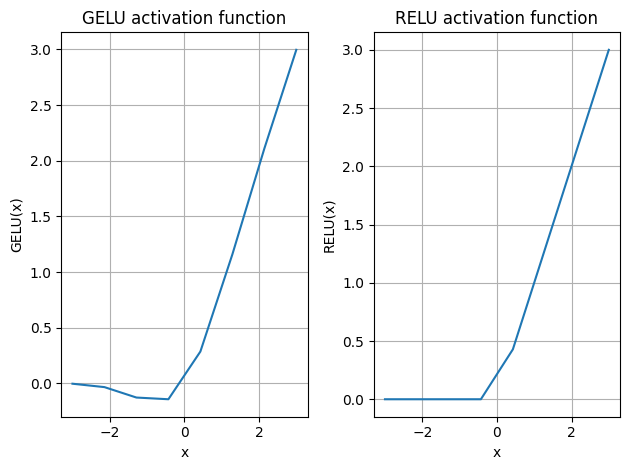

In [ ]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 8)
y_gelu, y_relu = gelu(x), relu(x)

# plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "RELU"]), 1): # counting starts from 1
  plt.subplot(1, 2, i)
  plt.plot(x, y)
  plt.title(f"{label} activation function")
  plt.xlabel("x")
  plt.ylabel(f"{label}(x)")
  plt.grid(True)
plt.tight_layout()
plt.show()

We can see that GELU allows for small non-zero output for negative values.


Now, we will use GELU function to implement `FeedForward` that will be used in the LLM’s transformer block later.

This `FeedForward` has two `Linear` layers and a `GELU` activation function.

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
        GELU(),
        nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
    )

  def forward(self, x):
    return self.layers(x)

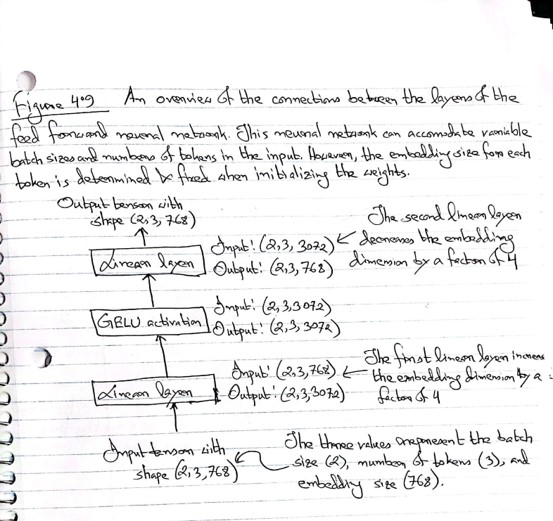

In [ ]:
display(Image(filename='4.9.jpg', width=800))

The **FeedForward module** is a critical component in transformer models, helping them learn complex patterns and generalize well from the data. Even though the input and output dimensions of this module remain the same, what happens inside is quite interesting and important.

Inside the FeedForward module:

1. The input embeddings (representations of words or tokens) are first passed through a **linear (fully connected) layer** that increases the dimension to a much **higher-dimensional space**. This expansion allows the model to explore and learn more intricate relationships between features.
2. After this expansion, the data goes through a **GELU (Gaussian Error Linear Unit)** activation function, which adds **non-linearity**. This non-linearity helps the model capture complex patterns that a simple linear transformation could not.
3. Finally, the output from the activation is passed through another **linear layer** that reduces the dimension back to the **original size**.

This process of expanding and then compressing the data is similar to how an autoencoder works, where a higher-dimensional representation acts like a "workspace" for the model to learn rich and diverse features before summarizing them back into the original space.

### **Why is this Important?**
- Without this intermediate expansion, the model would be limited in its ability to represent complex relationships.
- Think of it like working on a larger canvas to create intricate artwork before resizing it to fit into a smaller frame.

### **Analogy for Better Understanding:**
Imagine you're trying to solve a puzzle:

- Instead of working in a cramped space, you spread out all the pieces on a large table (expansion).
- You arrange the pieces carefully (applying non-linearity).
- Then, once the puzzle is complete, you pack it back into the box (compression).

### **Example with Dimensions:**
Let's say the input dimension is 512. Inside the FeedForward module:

- **First Linear Layer:** Expands from 512 to 2048 dimensions.
- **GELU Activation:** Applies non-linearity.
- **Second Linear Layer:** Compresses back from 2048 to 512.

This design ensures the model can explore a richer representation space, enabling it to capture complex patterns and improve performance across various tasks.

Now, let's use this `FeedForward` module.

In [ ]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


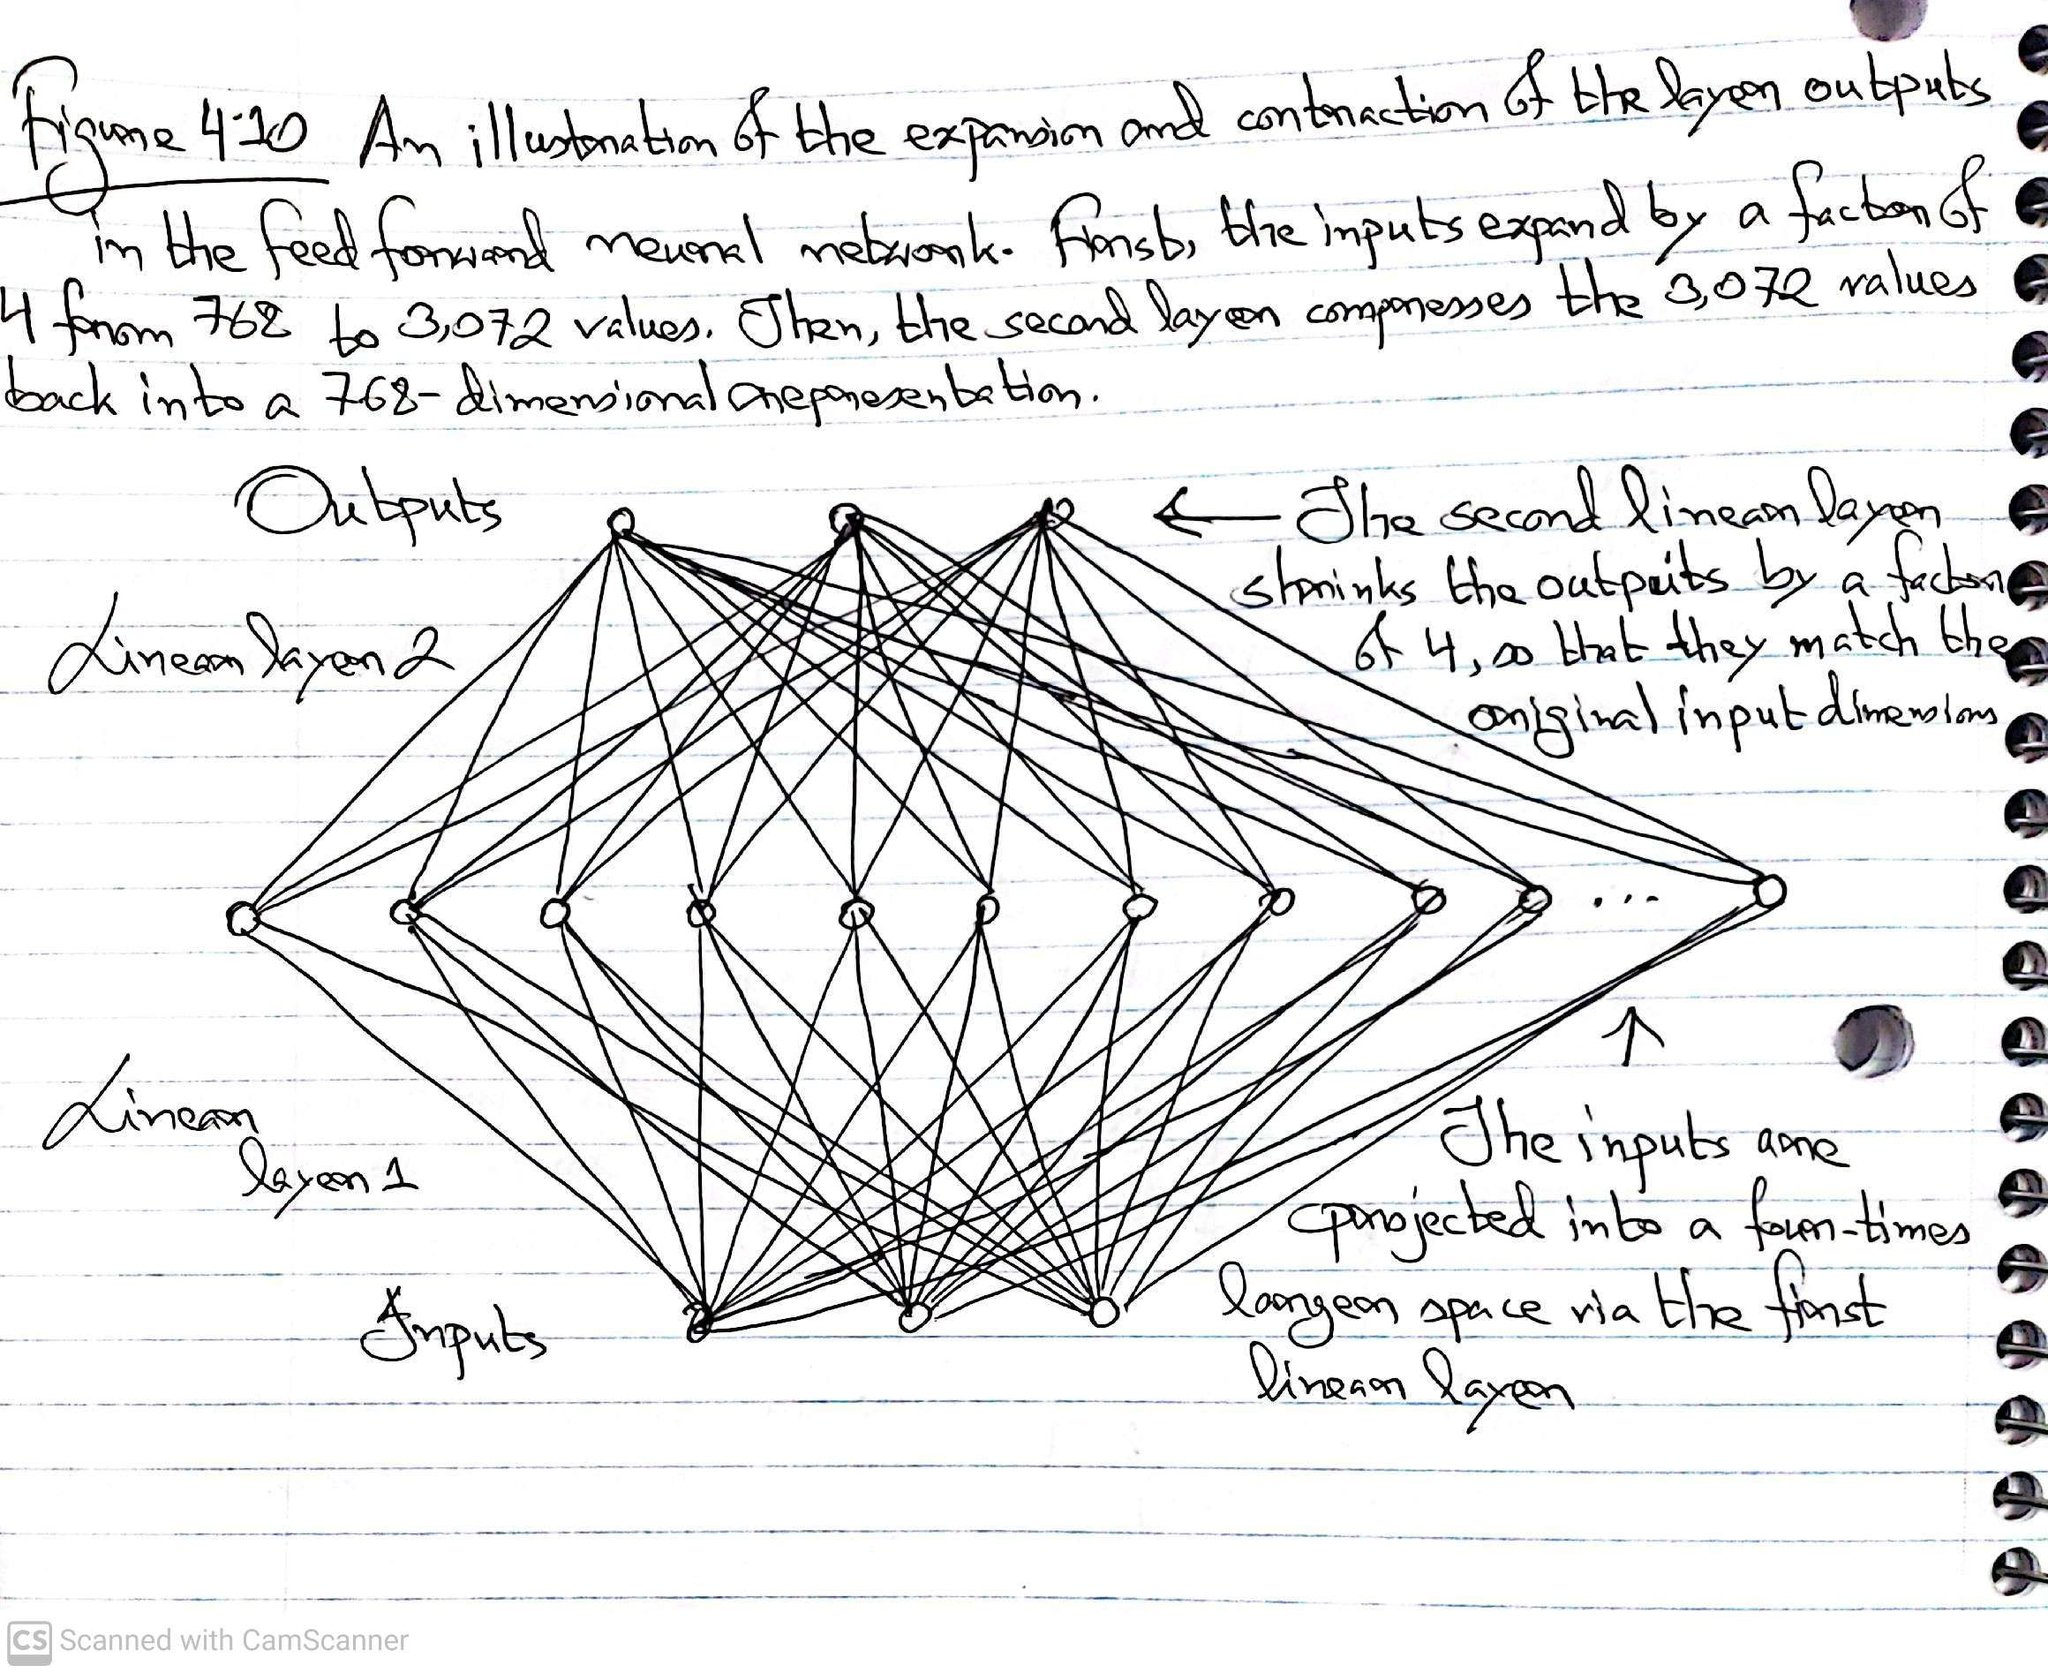

In [ ]:
display(Image(filename='4.10.jpg', width=800))

## **4.4 Adding shortcut connections**

Shortcut connections, or skip or residual connections were proposed for deep networks in computer vision to address the challenge of vanishing gradients (gradients becoming increasingly smaller as they propagate through the layers making it difficult to train easrlier layers).

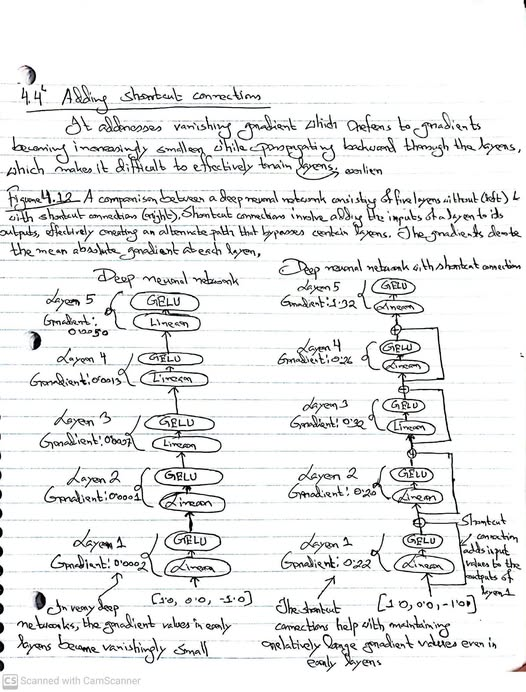

In [ ]:
display(Image(filename='4.12.jpg', width=800))

In this case, we create an alternate, shorter path for the gradient to flow through the network by skipping one or more layers. Shortcut connections are pathways in a neural network that bypass one or more layers by directly connecting the input of a layer to its output. Instead of the data flowing strictly through a sequence of layers, these connections allow data to "skip" over certain layers and be added directly to the output of deeper layers.

In [ ]:
class ExampleDeepNeuralNetwork(nn.Module):
  def __init__(self, layer_sizes, use_shortcut):
    super().__init__()
    self.use_shortcut = use_shortcut
    self.layers = nn.ModuleList([
        nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
        nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
        nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
        nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
        nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
    ])

  def forward(self, x):
    for layer in self.layers:
      layer_output = layer(x)
      if self.use_shortcut and x.shape == layer_output.shape:
        x = x + layer_output
      else:
        x = layer_output
    return x

`nn.Sequential()` is a convenient way to define a neural network layer-by-layer in PyTorch. It stacks multiple layers together in the exact order they are defined and automatically feeds the output of one layer as input to the next layer.

This deep neural network has five layers.

**DNN without shortcut connections**

In [ ]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

In [ ]:
def print_gradients(model, x):
  output = model(x)
  target = torch.tensor([[0.]])

  loss = nn.MSELoss()
  loss = loss(output, target) # Calculates the loss value by comparing the model's output with the target

  loss.backward() # Performs backpropagation to compute gradients of the loss with respect to each learnable parameter in the model

  for name, param in model.named_parameters(): # For a linear layer named fc1, it might yield ('fc1.weight', tensor(...)) and ('fc1.bias', tensor(...)).
    if 'weight' in name:
      print(f"{name} has gradient mean of {param.grad.abs().mean().item()}") # param.grad: Accesses the gradient tensor computed during loss.backward().

In [ ]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


****DNN with shortcut connections****

In [ ]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


## **4.5 Connecting attention and linear layers in a transformer block**

Now, we will implement transformer block which is a fundamental block of GPT and other LLM architectures. This block combines multi-head attention, layer normalization, dropout, feed forward layers and GELU activations. This block is repeated a dozen times in the 124-million parameter GPT-2 architecture.

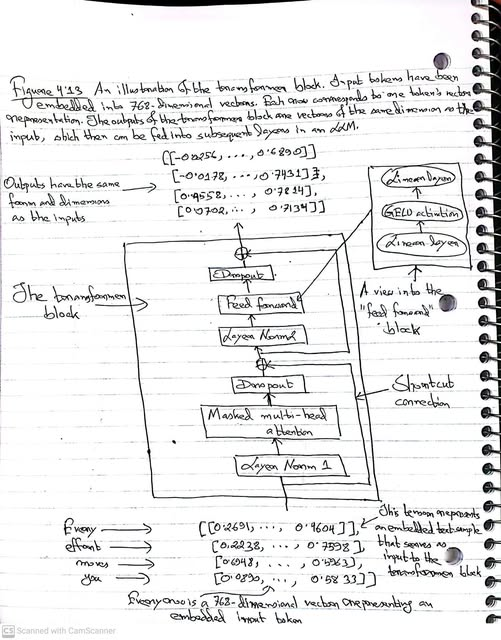

In [ ]:
display(Image(filename='4.13.jpg', width=800))

This explanation highlights two key components of the Transformer architecture: **multi-head self-attention** and the **feed-forward network**. Let’s break them down step by step.

### **Multi-Head Self-Attention Mechanism:**
- **What it does**: It helps the model determine relationships between different parts (or tokens) of the input sequence.
- **Why it matters:** In any sequence (like a sentence), each element (like a word) may depend on other elements, even those far apart. Self-attention helps the model weigh the importance of each element relative to the others.

#### **How it works**:
1. **Inputs are transformed into queries, keys, and values**:
  - Each token in the sequence is converted into three vectors:
    - **Query (Q)**: What this token is looking for in other tokens.
    - **Key (K)**: What information this token holds for others to find.
    - **Value (V)**: The actual content of the token.
2. **Attention scores are calculated**:
  - The model calculates scores by comparing each query with every key.
  - Higher scores mean the token is more relevant to another token.
3. **Weighted sums are computed**:
  - The values are combined based on the attention scores, meaning each token’s final representation is influenced by the most relevant tokens in the sequence.
4. **Multiple heads (multi-head attention)**:
- Instead of doing this once, multiple attention heads perform these operations independently.
- Each head focuses on different types of relationships (e.g., one head might focus on the subject-object relationship, another on the verb tense, etc.).

### **Feed-Forward Network (FFN)**:
- **What it does**: After the self-attention mechanism processes relationships between tokens, the feed-forward network processes each token independently.
- **Why it matters**: While self-attention focuses on context and relationships, the FFN focuses on refining each token’s representation independently.

#### **How it works**:
1. **Two linear transformations with an activation function in between**:
  - Each token’s vector is passed through a linear layer, followed by an activation function (like ReLU or GELU), and then another linear layer.
  - This helps the model learn complex transformations for each token, like adjusting its importance or refining its meaning.
2. **Per-token operation**:
  - The FFN doesn’t consider the relationships between tokens at this stage.
  - It processes each token separately, making it more fine-tuned for specific tasks like classification, translation, or summarization.

### **Why Both are Important**:
- **Self-Attention**: Provides a global view of the input sequence by capturing relationships between tokens.
- **Feed-Forward Network**: Provides local transformations by processing each token individually to enhance its representation.

### **In simpler terms**:
  - Imagine reading a book:
    - **Self-attention is like understanding how different characters relate to each other throughout the story**.
    - **The feed-forward network is like describing each character in detail after understanding their relationships**.

Combining both gives the model a better understanding of the entire sequence, making it highly effective for tasks involving complex data patterns.

Here is our previous code of `MultiHeadAttention` class.

In [ ]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        # Ensure that d_out is divisible by num_heads so each head has equal dimensions
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"

        self.d_out = d_out  # Output dimensionality (total for all heads combined)
        self.num_heads = num_heads  # Number of attention heads
        self.head_dim = d_out // num_heads  # Dimensionality of each head

        # Linear layers to project input into queries, keys, and values
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)  # Project input to query space
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)    # Project input to key space
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)  # Project input to value space

        # Final linear layer to combine the results of all heads
        self.out_proj = nn.Linear(d_out, d_out)

        # Dropout layer for regularization to prevent overfitting
        self.dropout = nn.Dropout(dropout)

        # Upper triangular mask to prevent attention to future tokens (causality)
        # Shape: (context_length, context_length)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        """
        x: Input tensor of shape (batch_size, num_tokens, d_in)
        """
        b, num_tokens, d_in = x.shape  # Extract batch size, number of tokens, and input dimensions

        # Project input x into queries, keys, and values
        keys = self.W_key(x)        # Shape: (batch_size, num_tokens, d_out)
        queries = self.W_query(x)  # Shape: (batch_size, num_tokens, d_out)
        values = self.W_value(x)   # Shape: (batch_size, num_tokens, d_out)

        # Split d_out into num_heads and head_dim for multi-head attention
        # Reshape keys, values, and queries to include a num_heads dimension
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)       # Shape: (batch_size, num_tokens, num_heads, head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)   # Shape: (batch_size, num_tokens, num_heads, head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim) # Shape: (batch_size, num_tokens, num_heads, head_dim)

        # Transpose num_tokens and num_heads for easier computation across heads
        keys = keys.transpose(1, 2)       # Shape: (batch_size, num_heads, num_tokens, head_dim)
        queries = queries.transpose(1, 2) # Shape: (batch_size, num_heads, num_tokens, head_dim)
        values = values.transpose(1, 2)   # Shape: (batch_size, num_heads, num_tokens, head_dim)

        # Compute scaled dot-product attention scores
        # Multiplying queries with keys (transposed) along head_dim
        attn_scores = queries @ keys.transpose(2, 3)  # Shape: (batch_size, num_heads, num_tokens, num_tokens)

        # Apply the causality mask to prevent attention to future tokens
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]  # Mask for current sequence length
        attn_scores.masked_fill_(mask_bool, -torch.inf)  # Set masked positions to negative infinity

        # Normalize attention scores using softmax along the last dimension (num_tokens)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)  # Shape: (batch_size, num_heads, num_tokens, num_tokens)

        # Apply dropout for regularization
        attn_weights = self.dropout(attn_weights)

        # Compute context vectors by multiplying attention weights with values
        context_vec = (attn_weights @ values)  # Shape: (batch_size, num_heads, num_tokens, head_dim)

        # Transpose back to original layout to combine the heads
        context_vec = context_vec.transpose(1, 2)  # Shape: (batch_size, num_tokens, num_heads, head_dim)

        # Flatten the multi-head output by merging num_heads and head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)  # Shape: (batch_size, num_tokens, d_out)

        # Final linear layer to combine information across heads
        context_vec = self.out_proj(context_vec)  # Shape: (batch_size, num_tokens, d_out)

        return context_vec

Below is the implementation of the transformer block.

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(d_in=cfg["emb_dim"], d_out=cfg["emb_dim"], context_length=cfg["context_length"],
                                  num_heads=cfg["n_heads"], dropout=cfg["drop_rate"], qkv_bias=cfg["qkv_bias"])
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):

    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut
    return x

The above code implements a **Transformer block**, a key component of the **Transformer architecture**. Here's the sequence of operations:

1. **Input to the block** (x) is received.

2. **Step 1: Attention Mechanism**

 - **LayerNorm** is applied to the input to stabilize it. (self.norm1(x))
 - The normalized input goes through the **Multi-Head Attention** layer (`self.att(x)`) to focus on relevant relationships within the input.
 - A `dropout layer` is applied to the attention output to prevent overfitting. (`self.drop_shortcut(x)`)
 - The **shortcut connection** (residual connection) adds the original input back to the attention output (`x = x + shortcut`).

3. **Step 2: Feed-Forward Neural Network**

 - The result from Step 1 is again normalized. (`self.norm2(x)`)
 - This normalized data is passed through a **Feed-Forward Neural Network** (`self.ff(x)`), which further processes the information.
 - Another dropout is applied for regularization (`self.drop_shortcut(x)`).
 - A **shortcut connection** adds the result of Step 1 back to the feed-forward output (`x = x + shortcut`).

4. **Final Output**

 - The final processed output of the Transformer block is returned.

This block is typically repeated multiple times in a Transformer model, where each block refines the information learned from the previous one.

In the code above, we see that layer normalization is applied before multi-head attention and feed forward network and dropout is applied immediately afterwards. This is called **Pre-LayerNorm**. In the original transformer model, this was applied afterwards and is known as Post-LayerNorm.

Now, instantiate a transformer block and feed some sample data.

In [ ]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


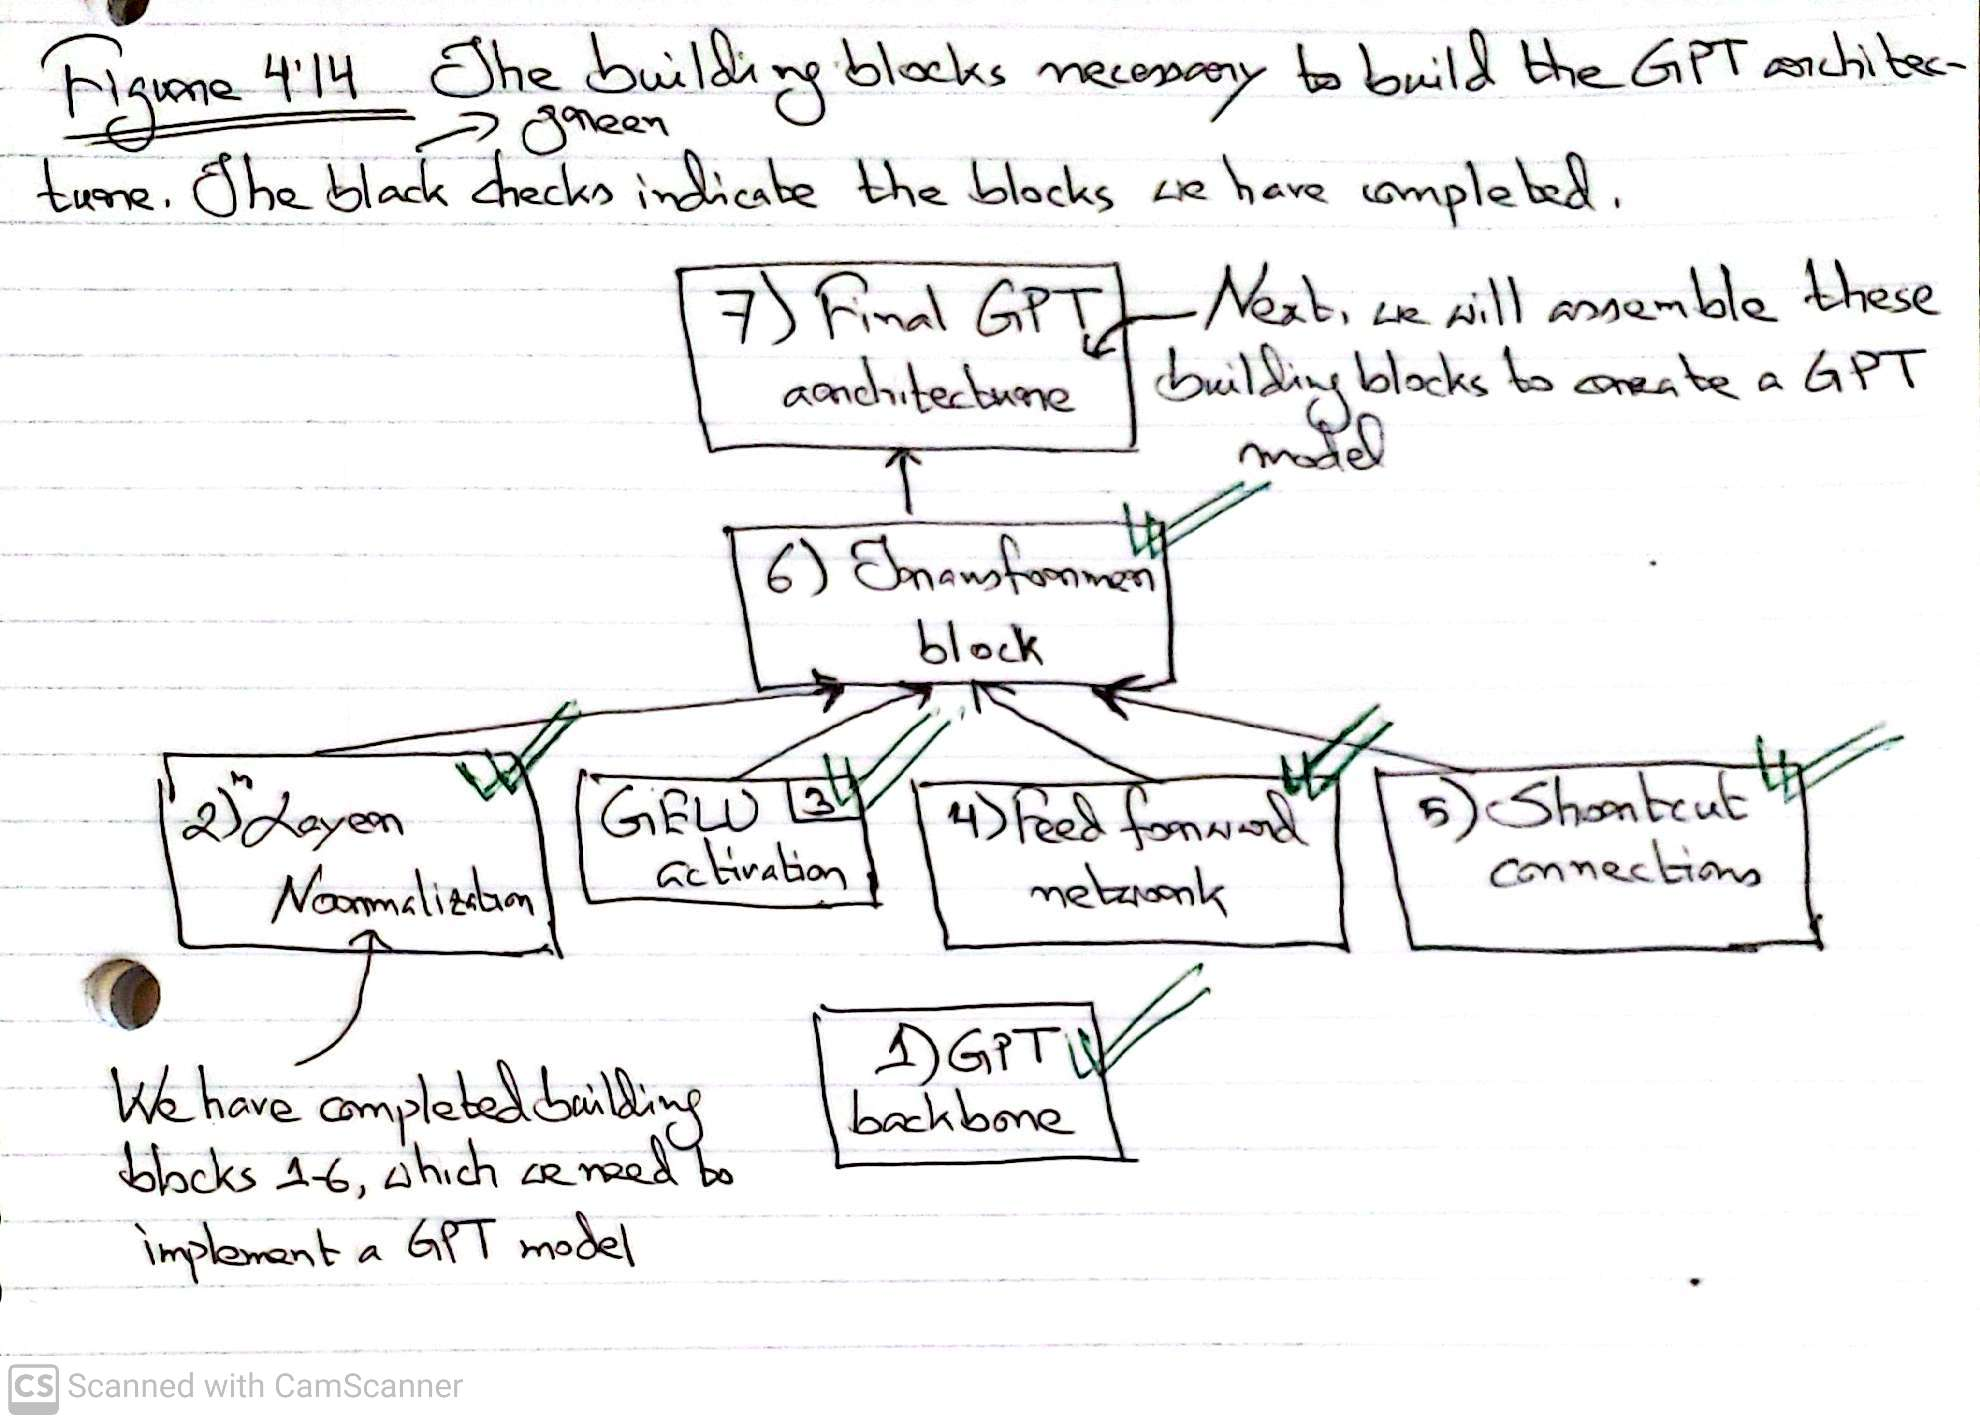

In [ ]:
display(Image(filename='4_14.jpg', width=800))

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 1024, # Context_length
    "emb_dim": 768, # Embedding dimension
    "n_layers": 12, # Number of transformer blocks
    "n_heads": 12, # Number of attention heads
    "drop_rate": 0.1, # Dropout rate
    "qkv_bias": False # Quer-Key-Value bias -- determines whether to include a bias vector in the Linear layers of the multi-head attention for query, key and value computations
}

## **4.6 Coding the GPT model**

Now, we will replace the `DummyTransformerBlock` and `DummyLayerNorm` placeholders with the real `TransformerBlock` and `LayerNorm` classes.

In [ ]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


2 inputs text, 4 tokens and 50257 vocabulary words correspond to the output tensor shape of `[2, 4, 50257]`.

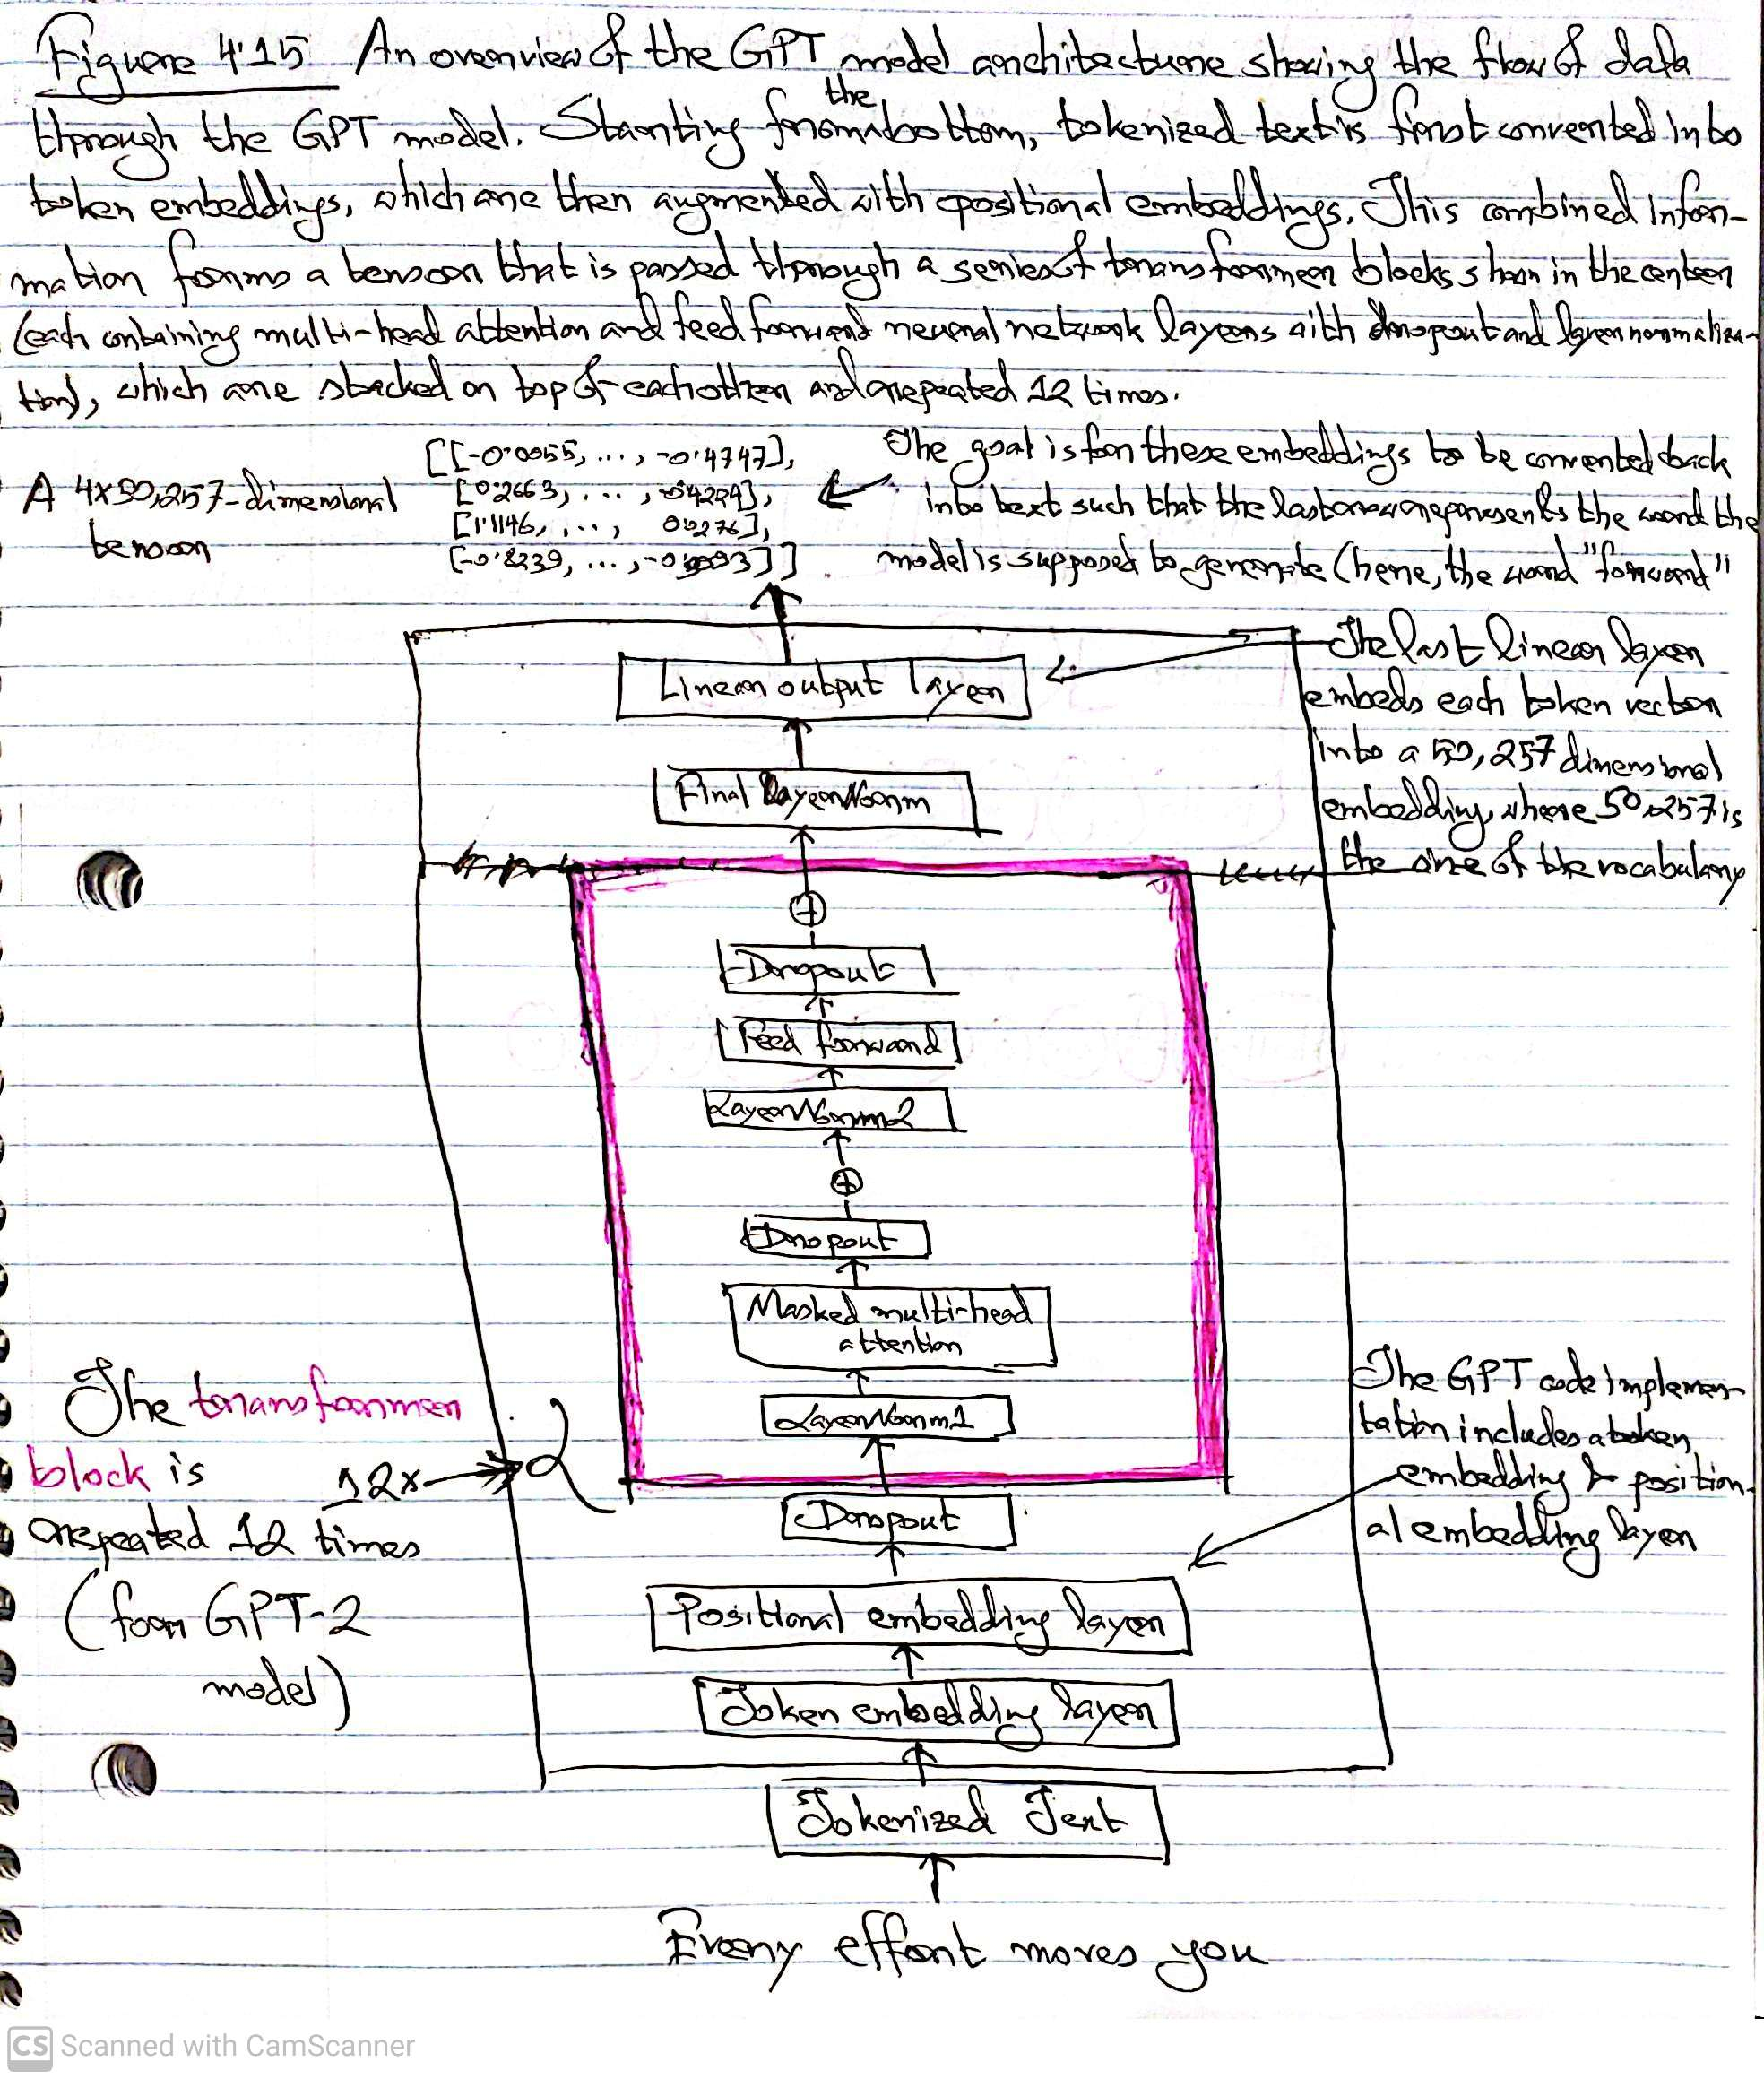

In [ ]:
display(Image(filename='4_15.jpg', width=800))

The total number of parameters in the model's parameter tensors:

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 163009536


We can see that the actual toal number of parameters is 163009536 but GPT-2 has the total parameter of 124 million. This is because original GPT-2 reuses the weights from the token embedding layer in its output layer.

In [ ]:
print("Total embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Total embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


Now, let's remove the output layer parameter count from the total GPT-2 model count.

In [ ]:
total_params_GPT_2 = (total_params - sum(p.numel() for p in model.out_head.parameters()))
print(f"Number of trainable parameters considering weight tying: {total_params_GPT_2}")

Number of trainable parameters considering weight tying: 124412160


Now, the model has 124 million parameters.

Now, we will compute the memory requirements of the 163 million parameters for the GPTModel object.

In [ ]:
total_size_bytes = total_params * 4  # 4 bytes per float32 parameter
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


## **4.7 Generating text**

Now, we will write the code to convert the tensor output of the GPT model nback to text. The figure below shows how LLM generates text one word at a time.

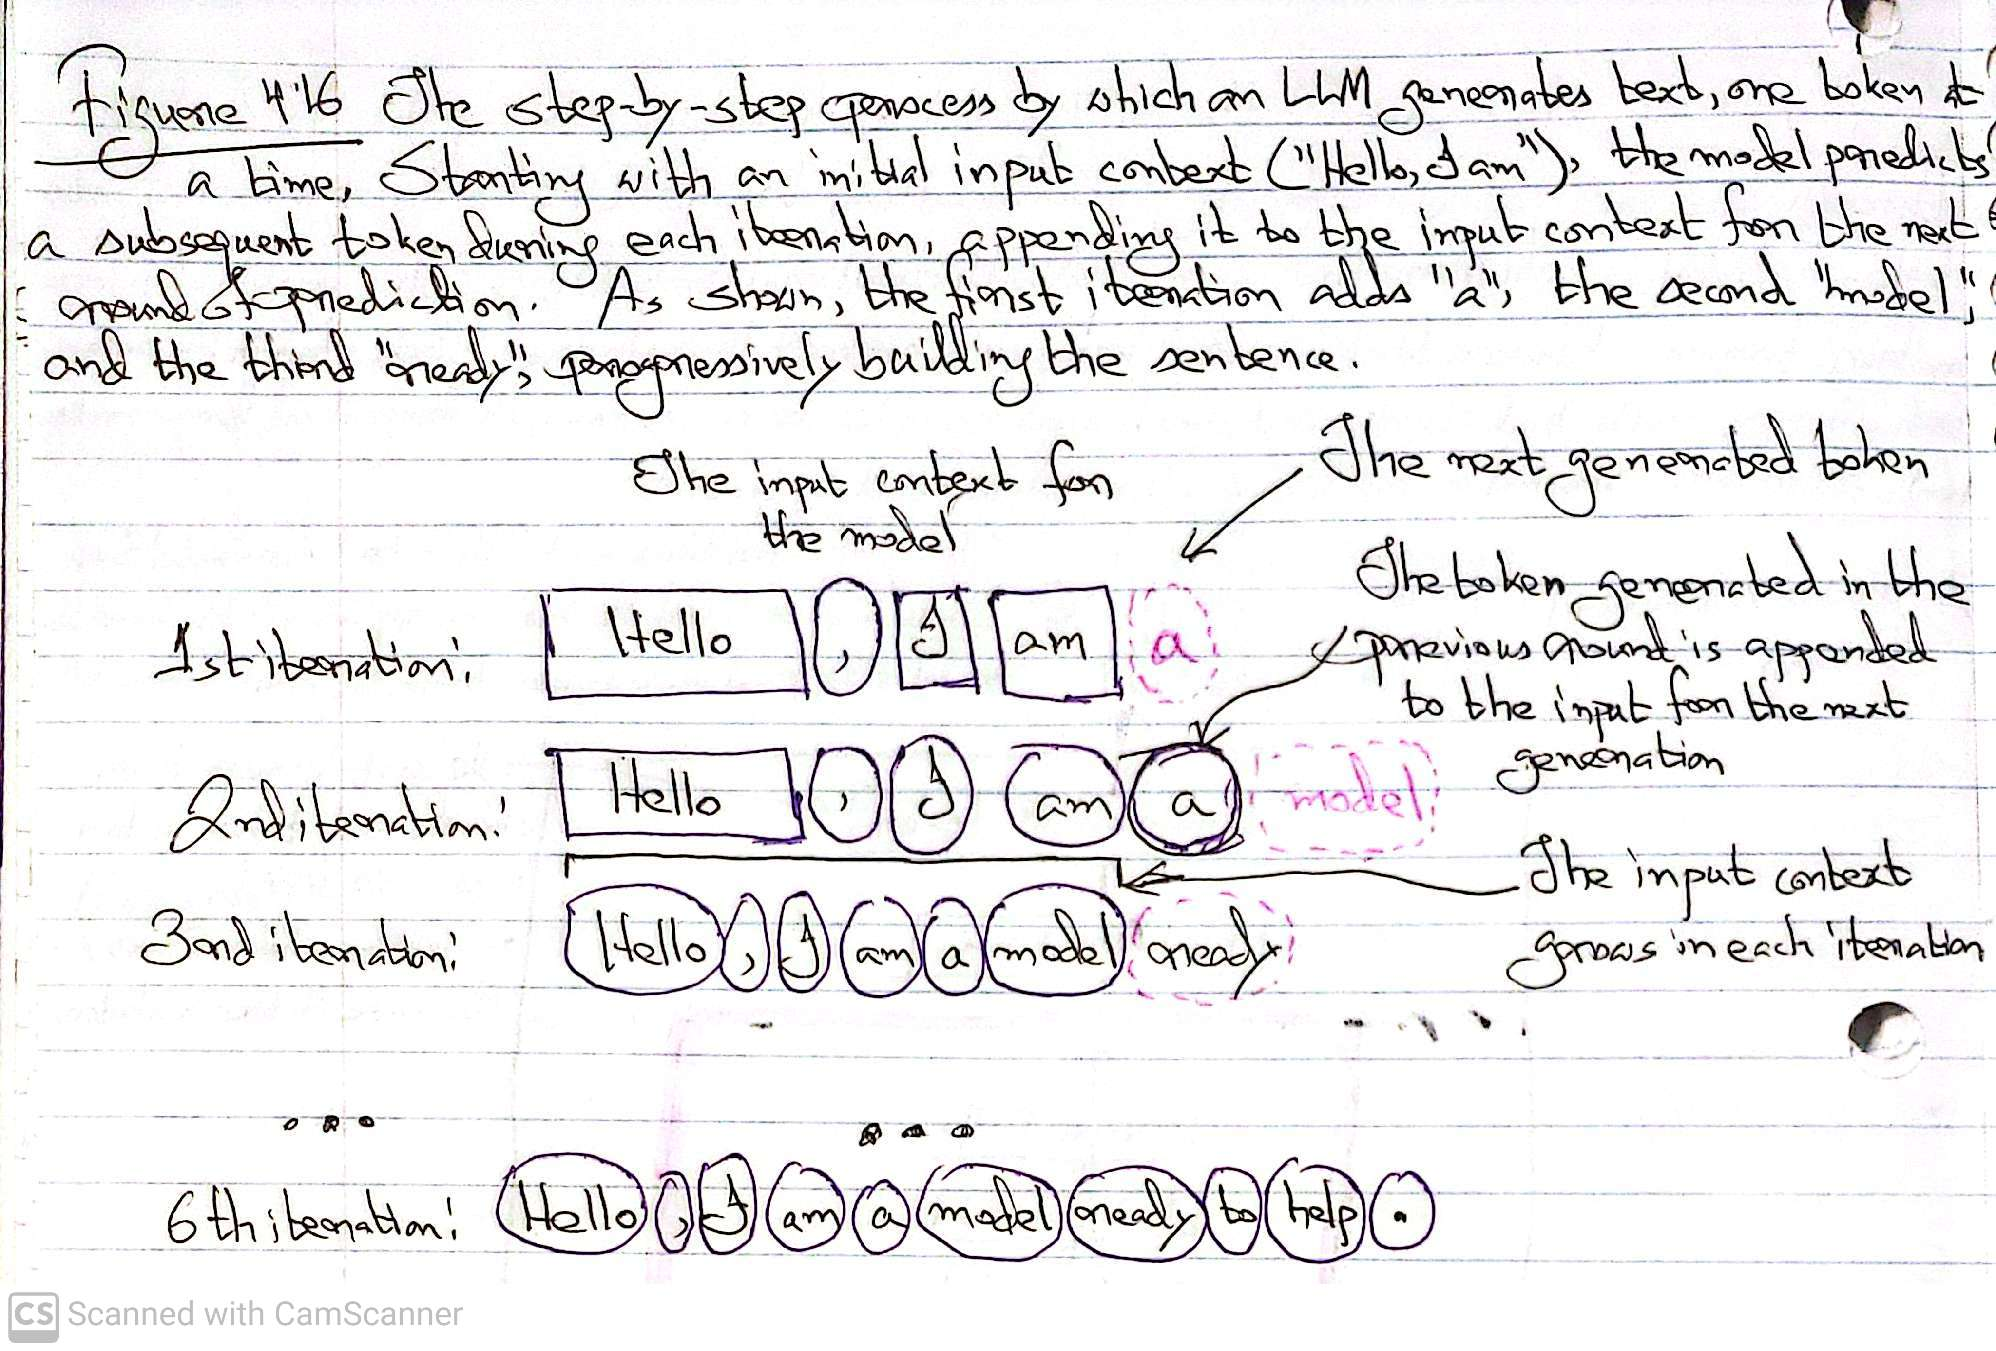

In [ ]:
display(Image(filename='4_16.jpg', width=800))

Our `GPTModel` outputs tensors with shape **[batch_size, num_token, vocab_size]**.

The following figure shows how GPT goes from output tensors to texts. Tokens are selected based on converting the GPT output to probability distribution using `softmax` function and then converting them to text. `softmax` function gives a vector of probability scores, then we select the index of the highest value and then get the text corresponding to that index. This then used as the next token in the sequence. This token is added to the previous inputs, which gives us a new input sequence for the subsequent iteration.

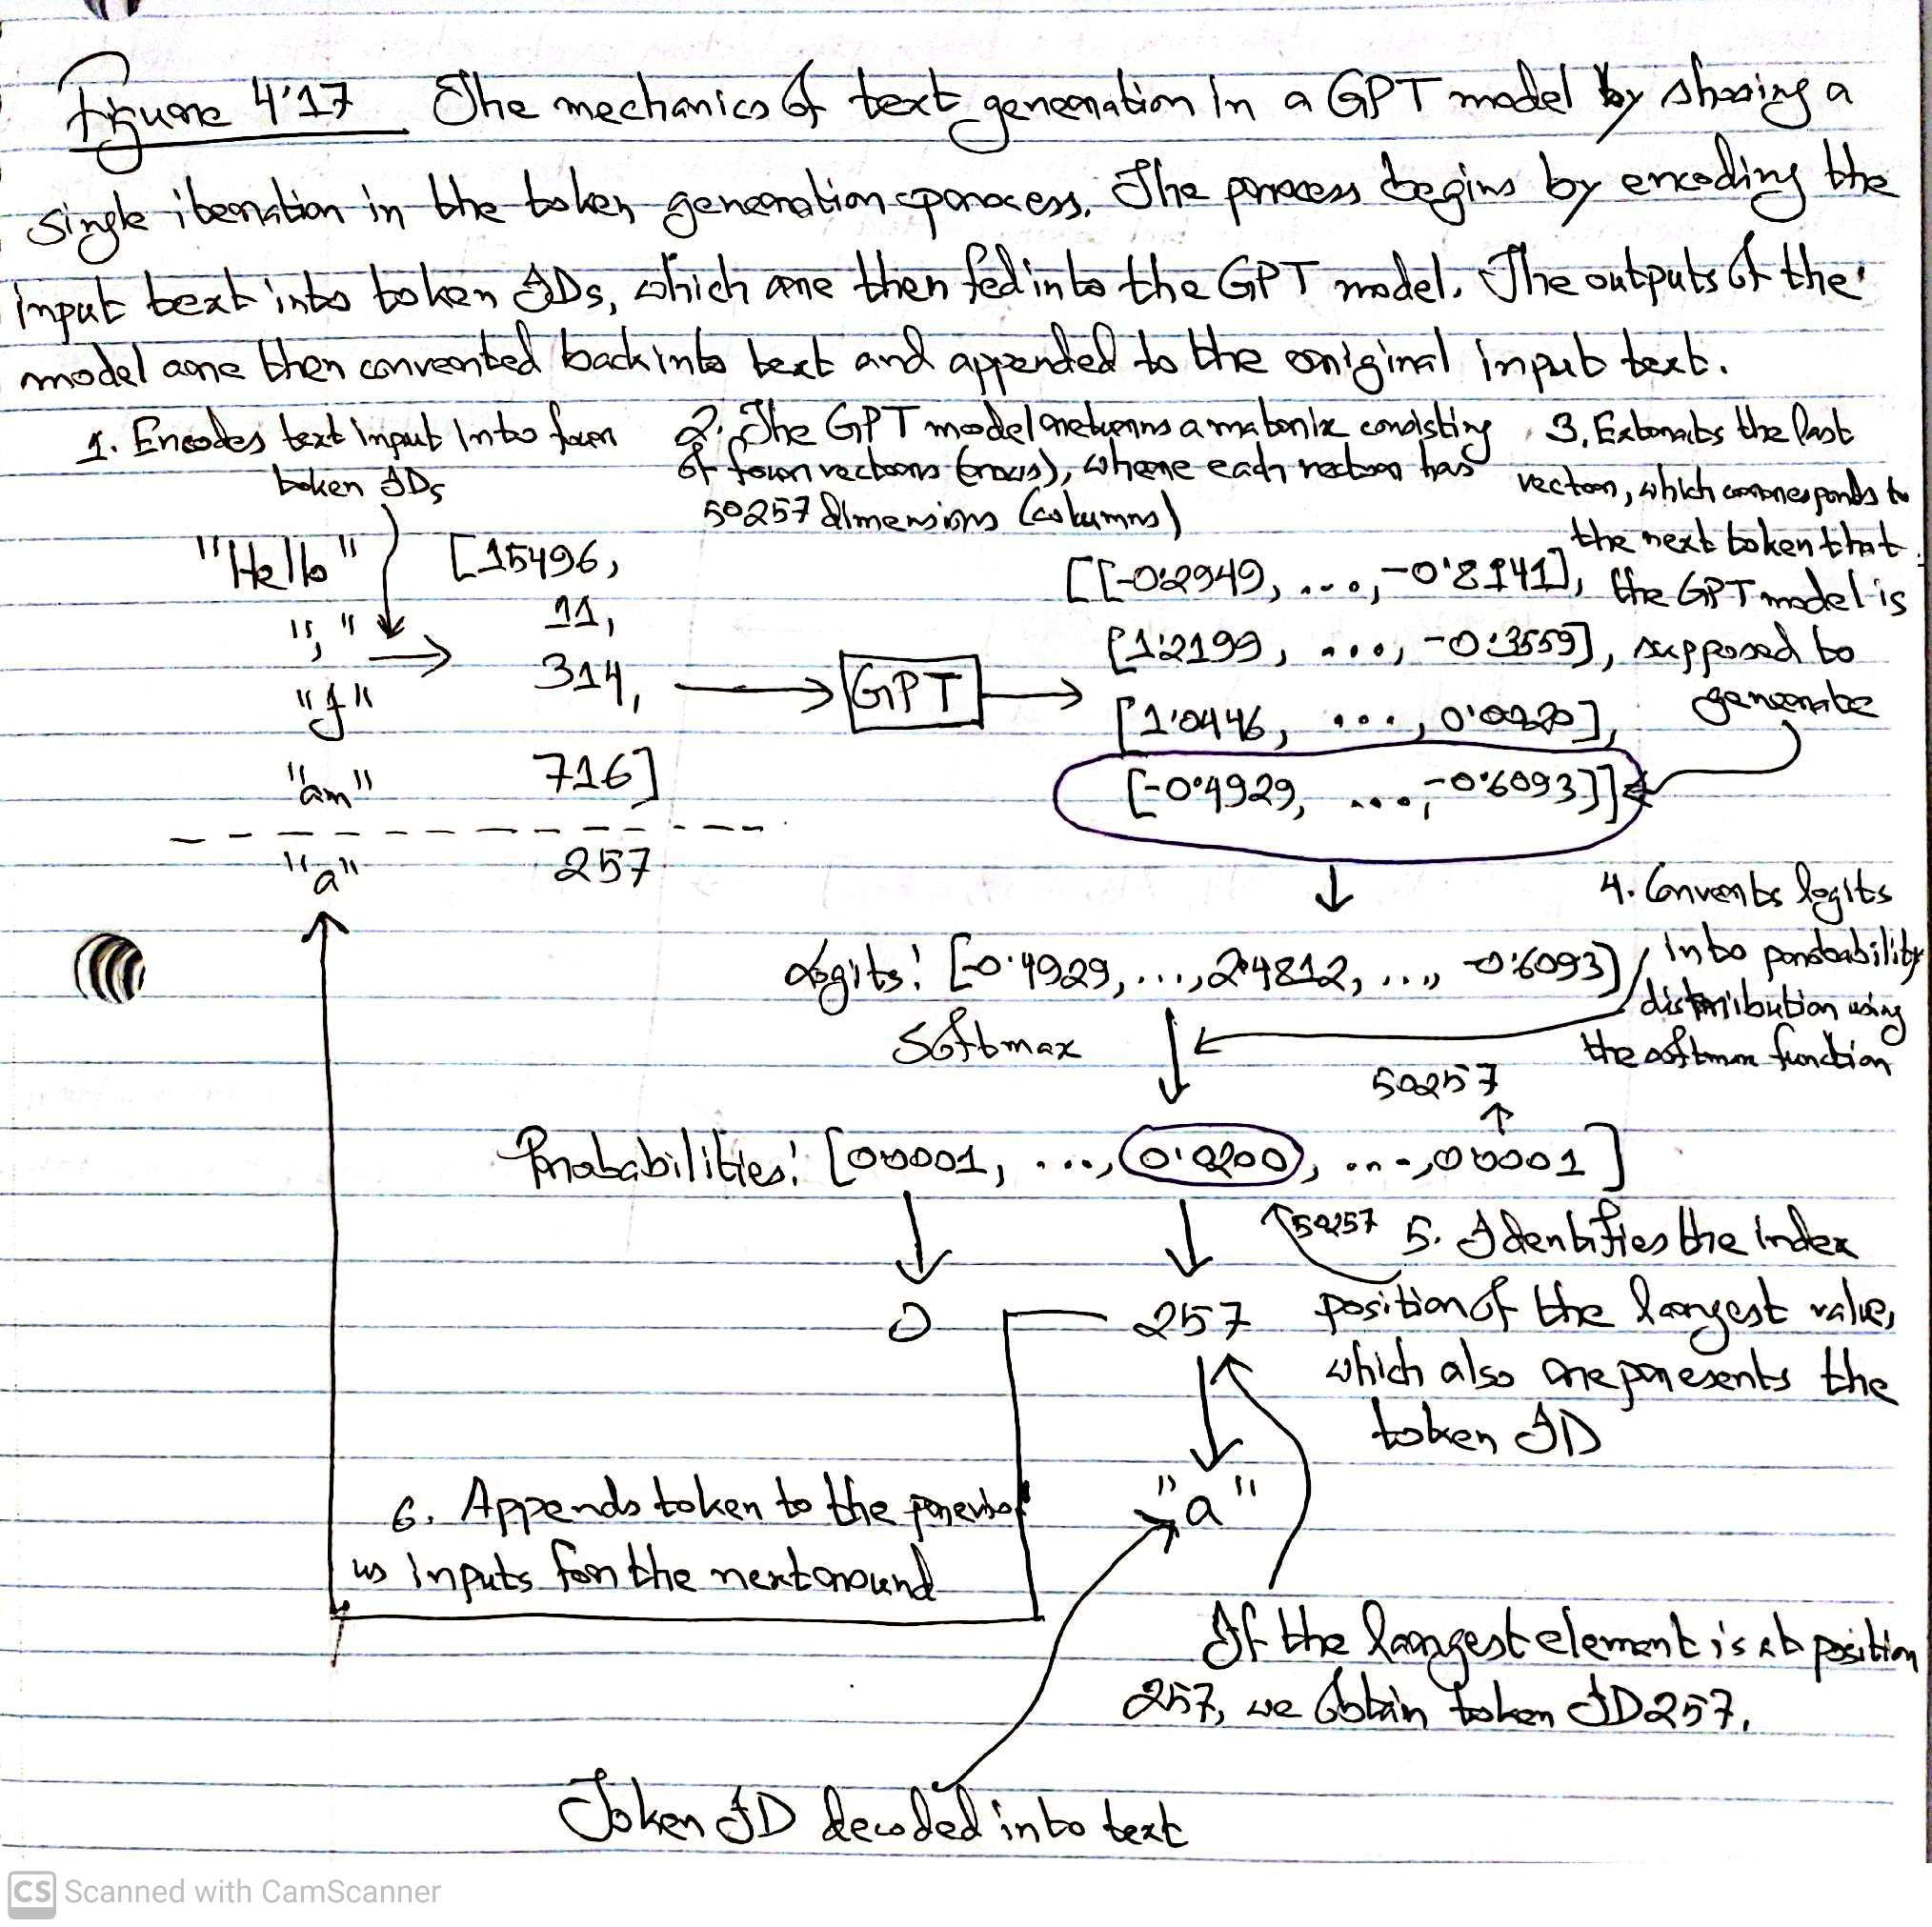

In [ ]:
display(Image(filename='4_17.jpg', width=800))

In [ ]:
def generate_text_simple(model, idx,
                         max_new_tokens, context_size): # max_new_tokens tells the number of tokens to add or predict
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :] # (batch, n_token, vocab_size) --> gives logits for the last token
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

logits shape -- (batch, number of tokens, vocabulary size)

In the next chapter (GPT training), we will use some sampling techniques for modifying softmax outputs so that the model doesn't always select the most likely token.

In [ ]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) # Makes it [1, 4] instead of the shape [4]
print("encoded tensor.shape", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded tensor.shape torch.Size([1, 4])


Now, we will use `eval()` mode as this will disable random components such as dropout that are used only during training.

In [ ]:
model.eval()
out = generate_text_simple(model=model, idx=encoded_tensor, max_new_tokens=6, context_size=GPT_CONFIG_124M["context_length"])
print("Output", out)
print("Output length:", len(out[0]))
print("Output shape: ", out.shape)

Output tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10
Output shape:  torch.Size([1, 10])


In [ ]:
out.squeeze(0).shape

torch.Size([10])

In [ ]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


As we haven't trained the model yet, it has produced this gibberish. Once we complete the training, we will get meaningful predictions.